In [100]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from prophet import Prophet
import warnings
import math
from math import sqrt
import time
warnings.filterwarnings("ignore")

## 1. Load consumption data


|Data                |Granularity |Year range|Source |
|--------------------|------------|----------|-------|
|Load consumption    |hourly      |2006-2023 |ENTSO-E|

In [101]:
# Load the dataset to explore trends and patterns
data_path = 'loadConsumption/data_2006_2023.csv'
data = pd.read_csv(data_path)

# Display basic information about the dataset
data.info(), data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157772 entries, 0 to 157771
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   loadConsumption  157772 non-null  float64
 1   date             157772 non-null  object 
 2   datetime         157772 non-null  object 
 3   Hour             157772 non-null  int64  
 4   Year             157772 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 6.0+ MB


(None,
    loadConsumption        date             datetime  Hour  Year
 0          10215.0  2006-01-01  2005-12-31 23:00:00     0  2006
 1           9979.0  2006-01-01  2006-01-01 00:00:00     1  2006
 2           9460.0  2006-01-01  2006-01-01 01:00:00     2  2006
 3           8833.0  2006-01-01  2006-01-01 02:00:00     3  2006
 4           8525.0  2006-01-01  2006-01-01 03:00:00     4  2006)

In [102]:
# Convert 'datetime' to pandas datetime for time-series operations
data['datetime'] = pd.to_datetime(data['datetime'])


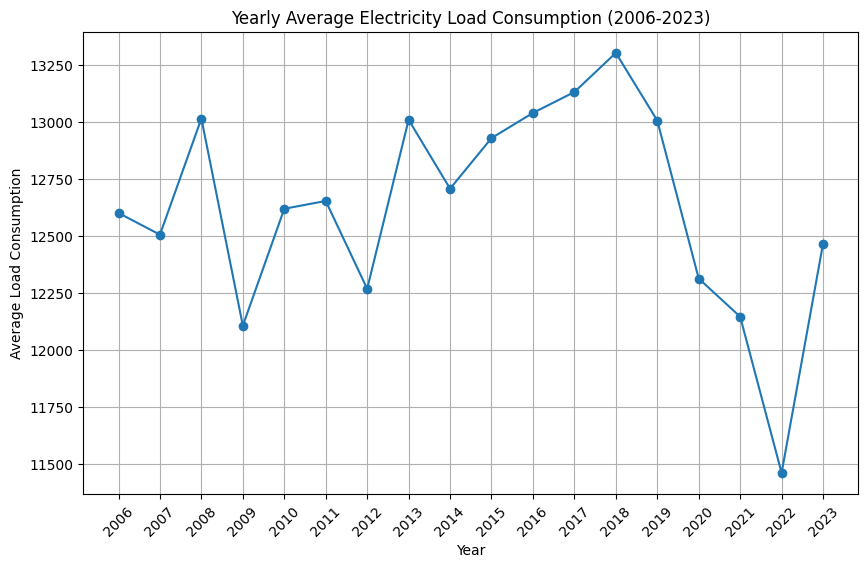

In [103]:
# Aggregate data for yearly trends
yearly_data = data.groupby('Year')['loadConsumption'].mean()

# Plot yearly trends
plt.figure(figsize=(10, 6))
plt.plot(yearly_data.index, yearly_data.values, marker='o')
plt.xticks(yearly_data.index, rotation=45)  
plt.title('Yearly Average Electricity Load Consumption (2006-2023)')
plt.xlabel('Year')
plt.ylabel('Average Load Consumption')
plt.grid()

plt.savefig("plots/yearly_load_consumption.png", dpi=300, bbox_inches='tight')

plt.show()

As it shows a very low average in 2022, I will check for enrty per year.

In [104]:
missing_data_info = data.isnull().sum()
missing_data_info

loadConsumption    0
date               0
datetime           0
Hour               0
Year               0
dtype: int64

Possible explination is corona

In [105]:
# Count the number of rows for each year
yearly_counts = data['Year'].value_counts().sort_index()

yearly_counts


Year
2006    8760
2007    8760
2008    8784
2009    8760
2010    8760
2011    8760
2012    8784
2013    8760
2014    8760
2015    8760
2016    8784
2017    8760
2018    8760
2019    8760
2020    8783
2021    8759
2022    8759
2023    8759
Name: count, dtype: int64

There is nothing concerning in the difference between rows number per year

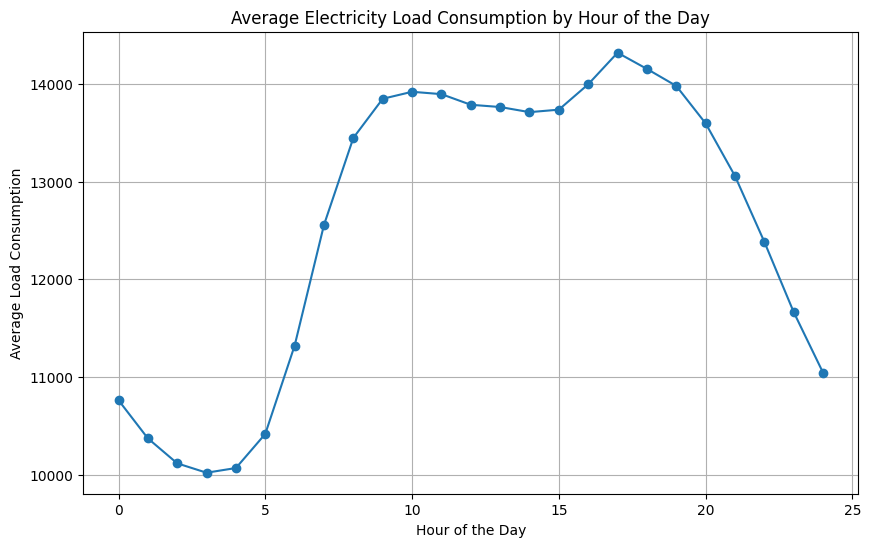

In [106]:
# Hourly patterns
hourly_data = data.groupby('Hour')['loadConsumption'].mean()

# Plot hourly trends
plt.figure(figsize=(10, 6))
plt.plot(hourly_data.index, hourly_data.values, marker='o')
plt.title("Average Electricity Load Consumption by Hour of the Day")
plt.xlabel("Hour of the Day")
plt.ylabel("Average Load Consumption")
plt.grid()

plt.savefig("plots/houraDay_load_consumption.png", dpi=300, bbox_inches='tight')

plt.show()


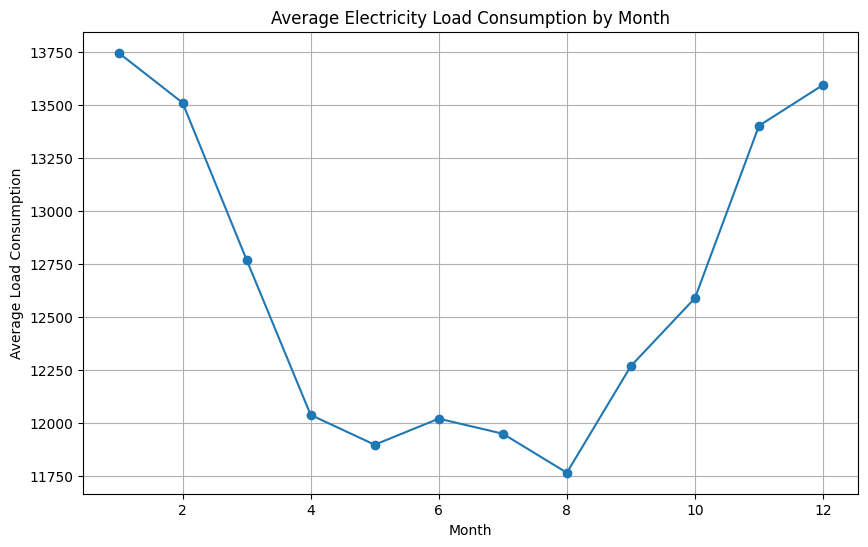

In [107]:
# Monthly patterns by extracting the month
data['Month'] = data['datetime'].dt.month
monthly_data = data.groupby('Month')['loadConsumption'].mean()

# Plot monthly trends
plt.figure(figsize=(10, 6))
plt.plot(monthly_data.index, monthly_data.values, marker='o')
plt.title("Average Electricity Load Consumption by Month")
plt.xlabel("Month")
plt.ylabel("Average Load Consumption")
plt.grid()

plt.savefig("plots/avgMonthly_load_consumption.png", dpi=300, bbox_inches='tight')

plt.show()


Clearly, there is more energy consumption during autumn and winter

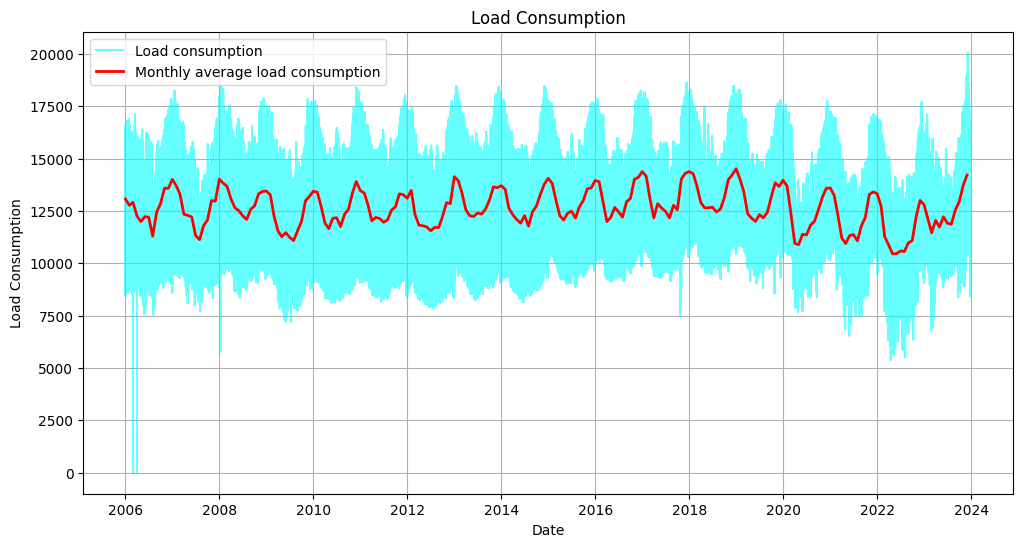

In [108]:
# Convert 'date' column to datetime if not already
data['date'] = pd.to_datetime(data['date'])

# Aggregate data for monthly average
data['Month'] = data['date'].dt.to_period('M')
monthly_data = data.groupby('Month')['loadConsumption'].mean()

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(data['date'], data['loadConsumption'], color='cyan', label='Load consumption', alpha=0.6)
plt.plot(monthly_data.index.to_timestamp(), monthly_data.values, color='red', linewidth=2, label='Monthly average load consumption')

# Add title and labels
plt.title('Load Consumption')
plt.xlabel('Date')
plt.ylabel('Load Consumption')
plt.legend()
plt.grid()
plt.show()


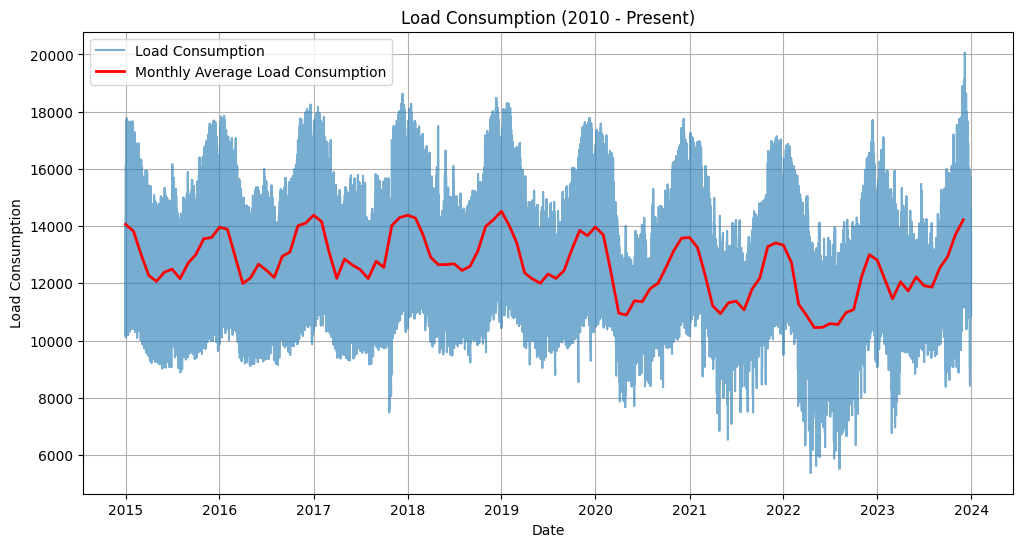

In [109]:
# Filter data from 2015 onwards
data_filtered = data[data['date'].dt.year >= 2015]

# Aggregate data for monthly average
data_filtered['Month'] = data_filtered['date'].dt.to_period('M')
monthly_data = data_filtered.groupby("Month")['loadConsumption'].mean()

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(data_filtered['date'], data_filtered['loadConsumption'], label='Load Consumption', alpha=0.6)  # Default color
plt.plot(monthly_data.index.to_timestamp(), monthly_data.values, color='red', linewidth=2, label='Monthly Average Load Consumption')

# Add title and labels
plt.title('Load Consumption (2010 - Present)')
plt.xlabel('Date')
plt.ylabel('Load Consumption')
plt.legend()
plt.grid()

# Save the plot
plt.savefig("plots/load_consumption_2015.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [110]:
# Identify outliers using the IQR method
Q1 = data['loadConsumption'].quantile(0.25)
Q3 = data['loadConsumption'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter rows with outliers
outliers = data[(data['loadConsumption'] < lower_bound) | (data['loadConsumption'] > upper_bound)]

# Display the outliers
outliers

,loadConsumption,date,datetime,Hour,Year,Month
1416,0.0000,2006-03-01,2006-02-28 23:00:00,0,2006,2006-03
2160,0.0000,2006-04-01,2006-03-31 23:00:00,0,2006,2006-04
142809,5383.1850,2022-04-17,2022-04-17 12:00:00,13,2022,2022-04
157188,20059.6425,2023-12-07,2023-12-07 16:00:00,17,2023,2023-12
157189,20019.3050,2023-12-07,2023-12-07 17:00:00,18,2023,2023-12
157190,19792.8075,2023-12-07,2023-12-07 18:00:00,19,2023,2023-12


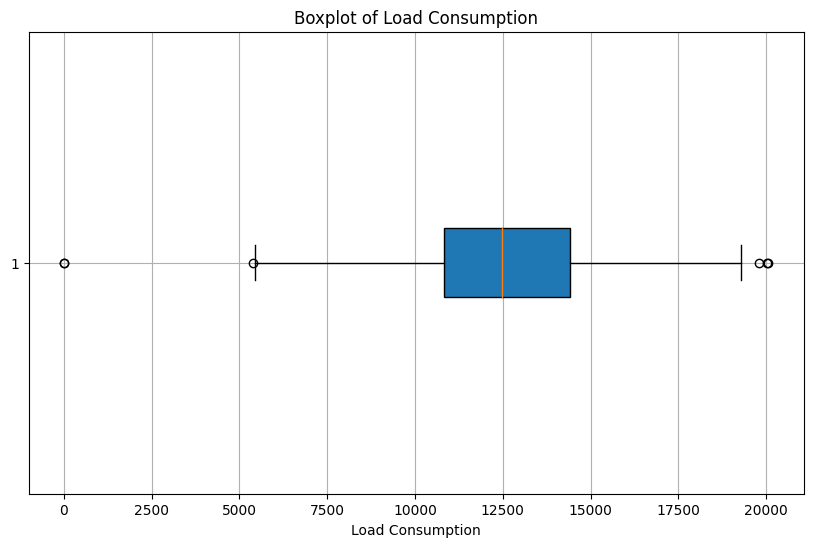

In [111]:
import matplotlib.pyplot as plt

# Check for outliers in the 'loadConsumption' column
plt.figure(figsize=(10, 6))
plt.boxplot(data['loadConsumption'], vert=False, patch_artist=True)
plt.title('Boxplot of Load Consumption')
plt.xlabel('Load Consumption')
plt.grid(True)
plt.show()


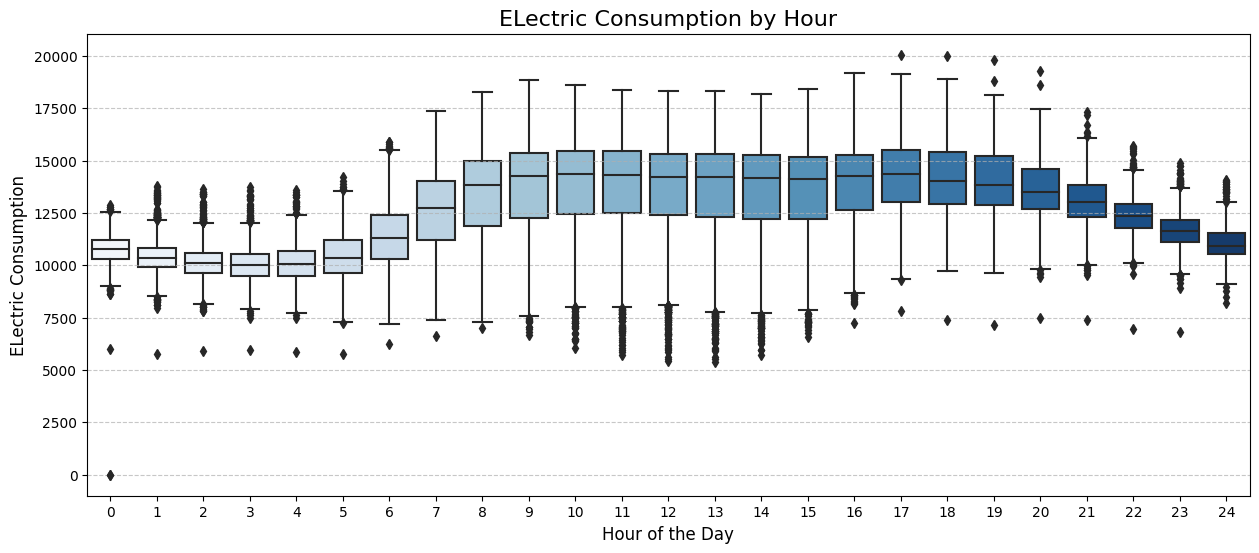

In [112]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(data=data, x='Hour', y='loadConsumption', palette='Blues')
ax.set_title('ELectric Consumption by Hour', fontsize=16)
ax.set_xlabel('Hour of the Day', fontsize=12)
ax.set_ylabel('ELectric Consumption', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

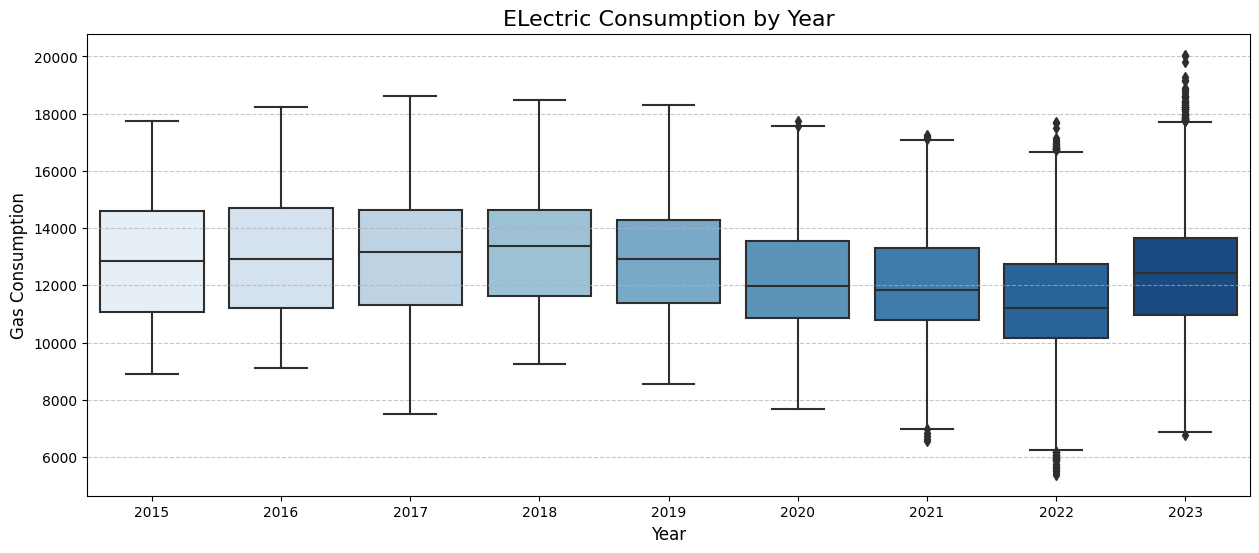

In [113]:
data_filtered = data[data['date'].dt.year >= 2015]

fig, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(data=data_filtered, x='Year', y='loadConsumption', palette='Blues')
ax.set_title('ELectric Consumption by Year', fontsize=16)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Gas Consumption', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.savefig("plots/ElecConsYear.png", dpi=300, bbox_inches='tight')

plt.show()

In [114]:
# Function to assign seasons based on the month
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

# Add a 'Season' as a column
data['Month'] = data['datetime'].dt.month  
data['Season'] = data['Month'].apply(get_season)  


data.head()


,loadConsumption,date,datetime,Hour,Year,Month,Season
0,10215.0,2006-01-01,2005-12-31 23:00:00,0,2006,12,Winter
1,9979.0,2006-01-01,2006-01-01 00:00:00,1,2006,1,Winter
2,9460.0,2006-01-01,2006-01-01 01:00:00,2,2006,1,Winter
3,8833.0,2006-01-01,2006-01-01 02:00:00,3,2006,1,Winter
4,8525.0,2006-01-01,2006-01-01 03:00:00,4,2006,1,Winter


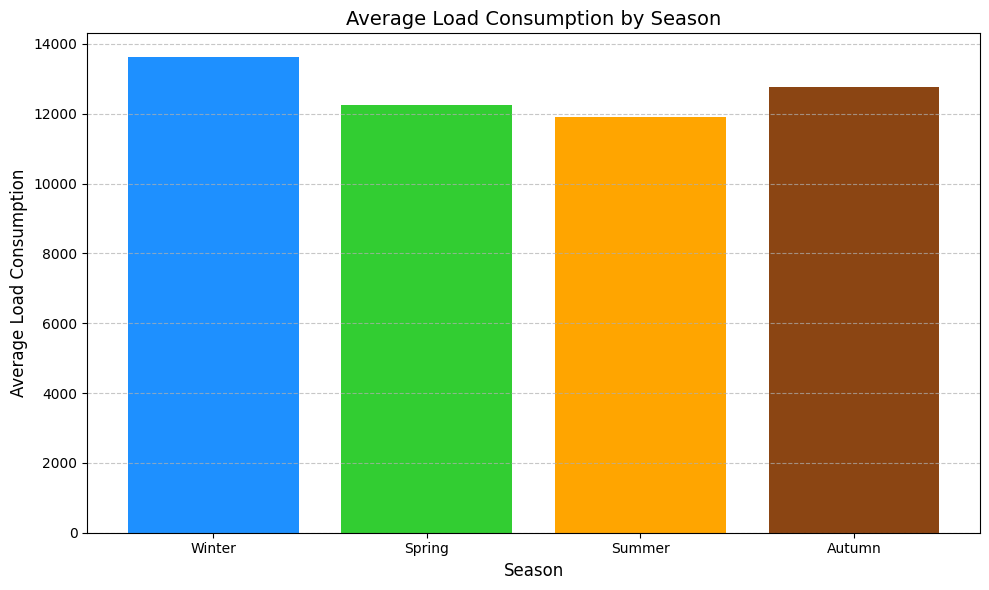

In [115]:
# Aggregate data by season and calculate the mean load consumption for each season
seasonal_data = data.groupby('Season')['loadConsumption'].mean()

# Sort the seasons in a logical order for visualization
season_order = ['Winter', 'Spring', 'Summer', 'Autumn']
seasonal_data = seasonal_data.reindex(season_order)

season_colors = ['#1E90FF', '#32CD32', '#FFA500', '#8B4513']  # Light Blue, Green, Orange, Brown

# Plot the seasonal trends with improved colors
plt.figure(figsize=(10, 6))
plt.bar(seasonal_data.index, seasonal_data.values, color=season_colors)

# Add title and labels
plt.title('Average Load Consumption by Season', fontsize=14)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Average Load Consumption', fontsize=12)

# Improve grid visibility
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Optimize layout
plt.tight_layout()

# Save the plot
plt.savefig("plots/seasonal_load_consumption.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


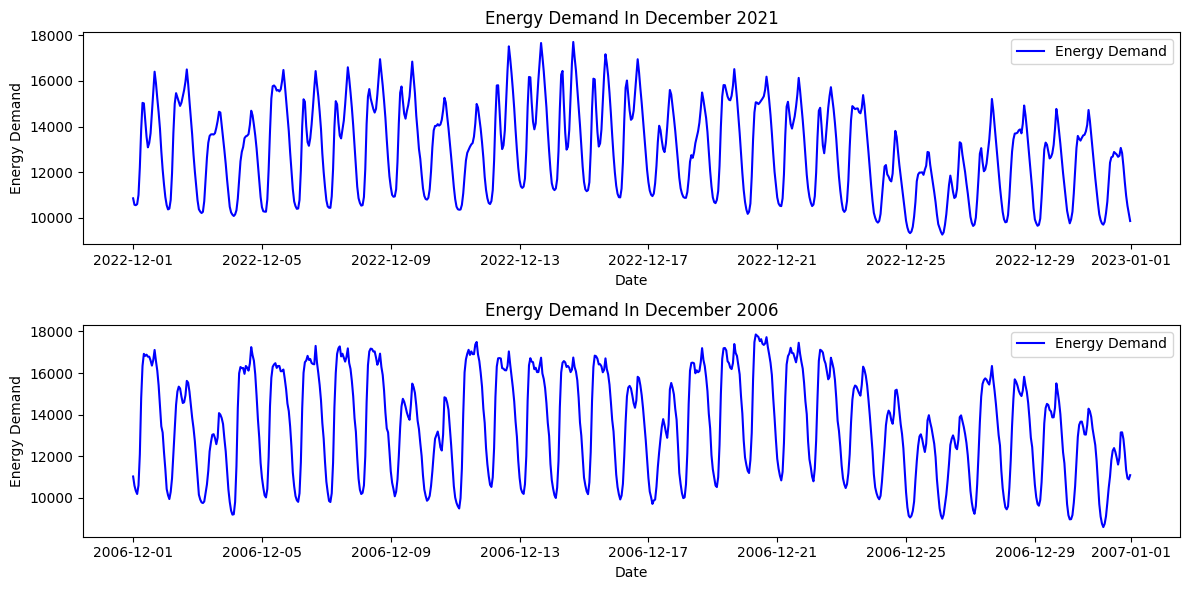

In [116]:
df_winter_2022_2023 = data[(data['datetime'] >= '2022-12-01') & (data['datetime'] < '2023-01-01')]
df_winter_2006_2007 = data[(data['datetime'] >= '2006-12-01') & (data['datetime'] < '2007-01-01')]

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(
    df_winter_2022_2023['datetime'], 
    df_winter_2022_2023['loadConsumption'], 
    label='Energy Demand', 
    color='blue')
plt.title('Energy Demand In December 2021')
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.legend()
plt.savefig("plots/loadDecember2021.png", dpi=300, bbox_inches='tight')


plt.subplot(2, 1, 2)
plt.plot(
    df_winter_2006_2007['datetime'], 
    df_winter_2006_2007['loadConsumption'],
    label='Energy Demand',
    color='blue')
plt.title('Energy Demand In December 2006')
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.legend()

plt.tight_layout()

plt.show()

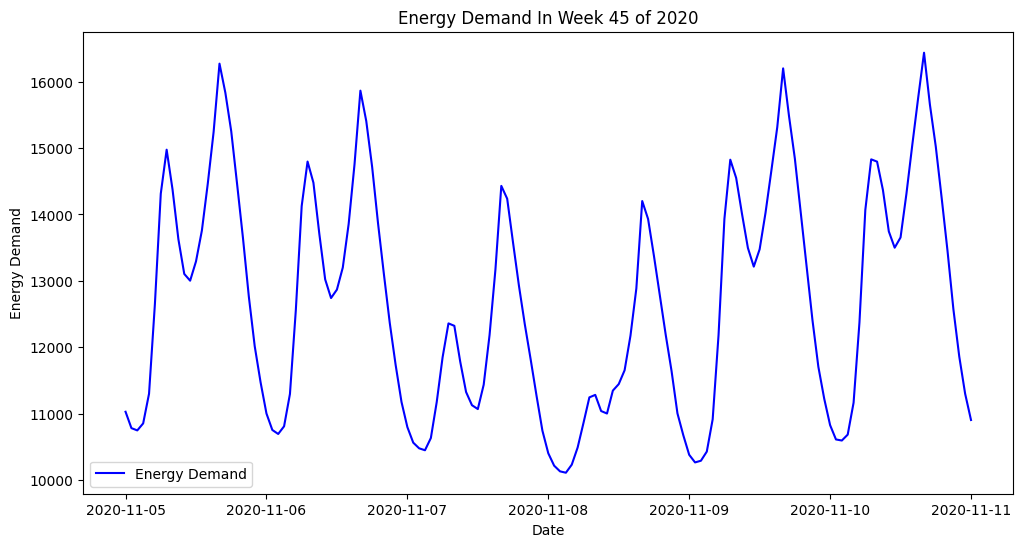

In [117]:
df_1_week = data[(data['datetime'] >= '2020-11-05') & (data['datetime'] <= '2020-11-11')]

plt.figure(figsize=(12, 6))
plt.plot(df_1_week['datetime'], df_1_week['loadConsumption'], label='Energy Demand', color='blue')
plt.title('Energy Demand In Week 45 of 2020')
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.legend()

plt.savefig("plots/week45020.png", dpi=300, bbox_inches='tight')


plt.show()

In [118]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import shapiro

def check_normality(df, feature):
    plt.figure(figsize=(6, 6))

    # histogram
    plt.hist(df[feature], edgecolor='black', bins=20)
    plt.title(f'Histogram of {feature}')

    # qq plot
    sm.qqplot(df[feature], line='45')
    plt.title(f'QQ plot of {feature}')

    plt.tight_layout()

    plt.show()

    # shapiro wilk
    print(shapiro(df[feature]))


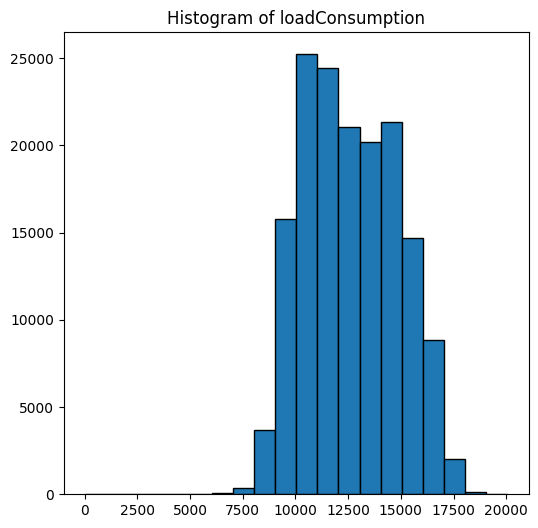

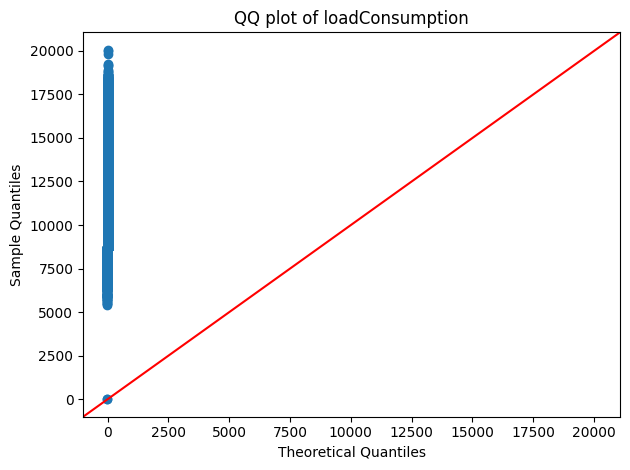

ShapiroResult(statistic=0.9795550107955933, pvalue=0.0)


In [119]:
check_normality(df=data, feature='loadConsumption')

In [120]:
data.isna().sum() / len(data)

loadConsumption    0.0
date               0.0
datetime           0.0
Hour               0.0
Year               0.0
Month              0.0
Season             0.0
dtype: float64

## 2. KNMI weather data

|Data     |Granularity |Year range|Source |
|---------|------------|----------|-------|
|Weather  |hourly/daily|1901-2024 |KNMI   |


The KNMI dataset contains lots of weather related variables. The column names are abbreviations, which we replace with full names. We select data from 2021 and on because that is the start date of our research. We cast some columns to the right format.

We choose these predictors from the dataset

|Abbreviation|Full name                 |Description                                                       |
|------------|--------------------------|------------------------------------------------------------------|
|YYYYMMDD    |Date                      | Date (YYYY=year MM=month DD=day)                                 |
|RH          |DailyPrecipitation        | Daily precipitation amount (in 0.1 mm) (-1 for <0.05 mm)         |
|RHX         |MaxHourlyPrecipitation    | Maximum hourly precipitation amount (in 0.1 mm) (-1 for <0.05 mm)|
|RHXH        |HDMaxPrecipitation*       | Hourly division in which RHX was measured                        |
|TG          |DailyMeanTemperature      | Daily mean temperature in (0.1 degrees Celsius)                  |
|TN          |HourlyMinTemperature      | Minimum temperature (in 0.1 degrees Celsius)                     |
|TNH         |HDMinTemperature*         | Hourly division in which TN was measured                         |
|TX          |HourlyMaxTemperature      | Maximum temperature (in 0.1 degrees Celsius)                     |
|TXH         |HDMaxTemperature*         | Hourly division in which TX was measured                         |
|FG          |DailyMeanWindspeed        | Daily mean windspeed (in 0.1 m/s)                                |
|FHN         |HourlyMinMeanWindspeed    | Minimum hourly mean windspeed (in 0.1 m/s)                       |
|FHNH        |HDMinMeanWindspeed*       | Hourly division in which FHN was measured                        |
|FHX         |HourlyMaxMeanWindspeed    | Maximum hourly mean windspeed (in 0.1 m/s)                       |
|FHXH        |HDMaxMeanWindspeed*       | Hourly division in which FHX was measured                        |

Where * HD = Hourly Division

In [121]:
def read_data(path: str) -> pd.DataFrame:
    """
    Read the data.
    Strip spaces from the columns.
    Rename all the columns (abbreviations -> full names).
    """

    weather = pd.read_csv(path)

    weather.columns = weather.columns.str.strip()
    weather = weather.applymap(lambda x: x.strip() if isinstance(x, str) else x)
    weather.replace('', None, inplace=True)

    column_mapping = {
        'YYYYMMDD': 'Date',
        'RH': 'DailyPrecipitation',
        'RHX': 'MaxHourlyPrecipitation',
        'RHXH': 'HDMaxPrecipitation',
        'TG': 'DailyMeanTemperature',
        'TN': 'HourlyMinTemperature',
        'TNH': 'HDMinTemperature',
        'TX': 'HourlyMaxTemperature',
        'TXH': 'HDMaxTemperature',
        'FG': 'DailyMeanWindspeed',
        'FHX': 'MaxHourlyMeanWindspeed',
        'FHXH': 'HDMaxMeanWindspeed',
        'FHN': 'MinHourlyMeanWindspeed',
        'FHNH': 'HDMinMeanWindspeed'
    }

    weather = weather[column_mapping.keys()]
    weather.rename(columns=column_mapping, inplace=True)

    return weather


def filter_on_year(weather: pd.DataFrame) -> pd.DataFrame:
    """
    Filter on only 1995 and later and reset index after filtering.
    """
    weather = weather[weather['Date'] >= 19950101]
    weather.reset_index(drop=True, inplace=True)

    return weather


def cast_datekey(weather: pd.DataFrame) -> pd.DataFrame:
    """
    Cast datekey 19950101 to format 1995/01/01
    """
    weather['Date'] = pd.to_datetime(weather['Date'], format='%Y%m%d').dt.strftime('%Y/%m/%d')

    return weather


def cast_hour_columns(weather: pd.DataFrame) -> pd.DataFrame:
    """
    Cast hour columns to integer.
    """
    hour_cols = [
        'HDMaxPrecipitation',
        'HDMinTemperature',
        'HDMaxTemperature',
        'HDMaxMeanWindspeed',
        'HDMinMeanWindspeed'
    ]

    for i in hour_cols:
        weather[i] = weather[i].astype(int)

    return weather


def convert_columns(weather: pd.DataFrame) -> pd.DataFrame:
    """
    Divide the following columns by 10 to get actual number, since they are 0.1 of the actual number.
    """
    cols_to_convert = [
        'DailyPrecipitation',
        'MaxHourlyPrecipitation',
        'DailyMeanTemperature',
        'HourlyMaxTemperature',
        'DailyMeanWindspeed',
        'MinHourlyMeanWindspeed',
        'MaxHourlyMeanWindspeed'
    ]
    for i in cols_to_convert:
        weather[i] = weather[i] / 10

    return weather


def create_date_columns(weather: pd.DataFrame) -> pd.DataFrame:
    """
    Cast date column (2021-01-01 instead of 2021/01/01) and add month and year columns
    Create a week key combining year and week number
    """
    weather['Date'] = pd.to_datetime(weather['Date'], format='%Y/%m/%d')
    weather['Month'] = weather['Date'].dt.month
    weather['Year'] = weather['Date'].dt.year
    weather['Week'] = weather['Date'].dt.isocalendar().week

    weather['WeekKey'] = weather['Year'].astype(str) + weather['Week'].apply(lambda x: '{:02d}'.format(x))
    weather['day_of_week'] = weather['Date'].dt.day_name()

    return weather


def preprocess_weather(path: str) -> pd.DataFrame:
    """
    Preprocess the weather data.
    """
    weather = read_data(path)
    weather = filter_on_year(weather)
    weather = cast_datekey(weather)
    weather = cast_hour_columns(weather)
    weather = convert_columns(weather)
    weather = create_date_columns(weather)

    return weather

In [122]:
weather_path = 'raw_data/deBilt.csv'

weather = preprocess_weather(weather_path)

weather

,Date,DailyPrecipitation,MaxHourlyPrecipitation,HDMaxPrecipitation,DailyMeanTemperature,HourlyMinTemperature,HDMinTemperature,HourlyMaxTemperature,HDMaxTemperature,DailyMeanWindspeed,MaxHourlyMeanWindspeed,HDMaxMeanWindspeed,MinHourlyMeanWindspeed,HDMinMeanWindspeed,Month,Year,Week,WeekKey,day_of_week
0,1995-01-01,8.3,1.7,12,2.0,2,14,3.8,19,4.6,7.7,20,2.6,1,1,1995,52,199552,Sunday
1,1995-01-02,3.2,1.2,4,3.0,-12,24,5.9,12,4.6,7.7,7,1.0,24,1,1995,1,199501,Monday
2,1995-01-03,-0.1,-0.1,3,-0.5,-38,24,2.3,14,2.1,3.1,12,1.0,1,1,1995,1,199501,Tuesday
3,1995-01-04,0.0,0.0,1,-2.8,-48,21,0.3,14,2.6,4.1,14,2.1,1,1,1995,1,199501,Wednesday
4,1995-01-05,0.0,0.0,1,-3.9,-59,8,-1.8,14,5.7,7.7,21,3.1,1,1,1995,1,199501,Thursday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10968,2025-01-11,-0.1,-0.1,1,0.5,-45,8,5.8,14,1.5,3.0,14,0.0,7,1,2025,2,202502,Saturday
10969,2025-01-12,0.1,0.1,21,1.7,-6,22,6.0,14,1.2,2.0,5,1.0,1,1,2025,2,202502,Sunday
10970,2025-01-13,0.0,0.0,1,0.5,-33,5,5.2,14,2.2,4.0,13,1.0,1,1,2025,3,202503,Monday
10971,2025-01-14,0.1,0.1,20,2.8,-16,1,5.7,24,3.1,5.0,13,2.0,6,1,2025,3,202503,Tuesday


In [123]:
weather.isna().sum() / len(weather)

Date                      0.0
DailyPrecipitation        0.0
MaxHourlyPrecipitation    0.0
HDMaxPrecipitation        0.0
DailyMeanTemperature      0.0
HourlyMinTemperature      0.0
HDMinTemperature          0.0
HourlyMaxTemperature      0.0
HDMaxTemperature          0.0
DailyMeanWindspeed        0.0
MaxHourlyMeanWindspeed    0.0
HDMaxMeanWindspeed        0.0
MinHourlyMeanWindspeed    0.0
HDMinMeanWindspeed        0.0
Month                     0.0
Year                      0.0
Week                      0.0
WeekKey                   0.0
day_of_week               0.0
dtype: float64

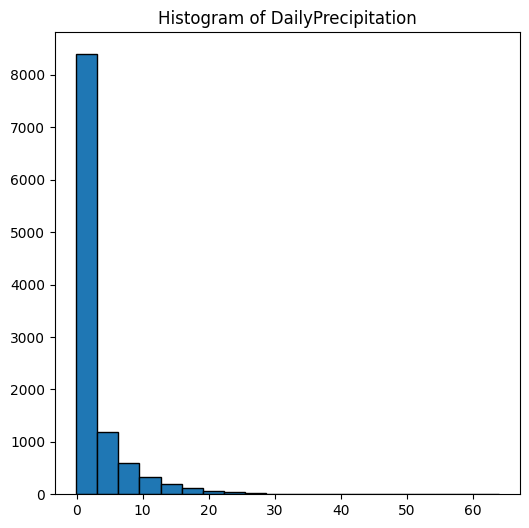

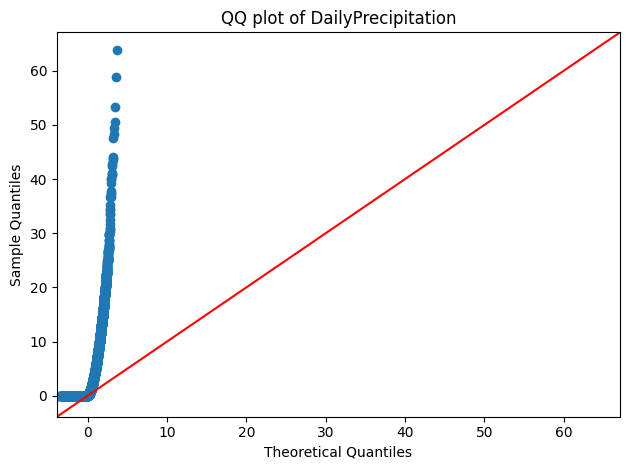

ShapiroResult(statistic=0.567188024520874, pvalue=0.0)


In [124]:
check_normality(df=weather, feature='DailyPrecipitation')

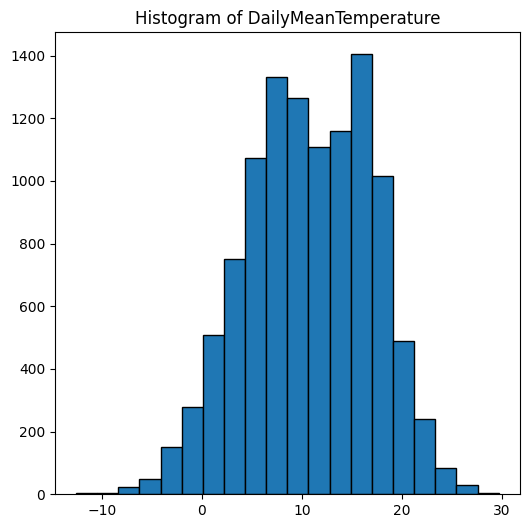

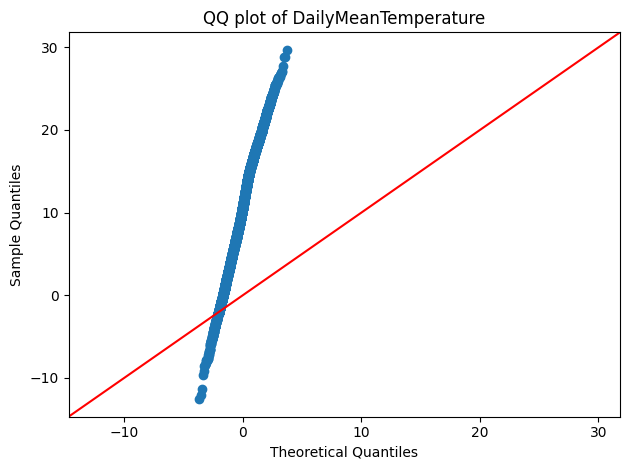

ShapiroResult(statistic=0.9928660988807678, pvalue=5.883746198406056e-23)


In [125]:
check_normality(df=weather, feature='DailyMeanTemperature')

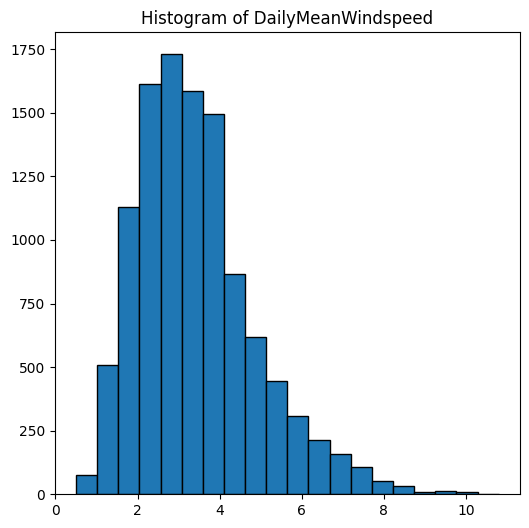

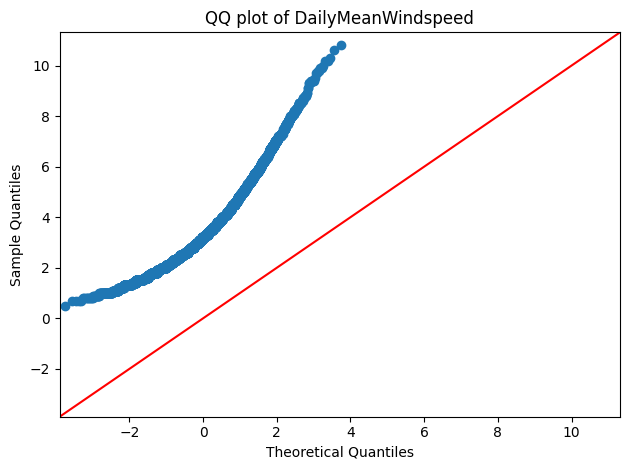

ShapiroResult(statistic=0.9450923800468445, pvalue=0.0)


In [126]:
check_normality(df=weather, feature='DailyMeanWindspeed')

In [216]:
weather.to_csv('processed_data/weather.csv', index = False)

### Energy Price

In [133]:
energyPrice_path = 'raw_data/energyConsPricesNl2009.csv'
energyPriceNl = pd.read_csv(energyPrice_path, delimiter=';')


In [134]:
energyPriceNl.columns.tolist()


['Prijscomponenten',
 'Belastingen',
 'Perioden',
 'Aardgasprijs/Verbruiksklassen huishoudens/Minder dan 569 m3 (euro per m3)',
 'Aardgasprijs/Verbruiksklassen huishoudens/569 tot 5 687 m3 (euro per m3)',
 'Aardgasprijs/Verbruiksklassen huishoudens/5 687 m3 en meer (euro per m3)',
 'Aardgasprijs/Verbruiksklassen niet-huishoudens/Minder dan 28 433 m3 (euro per m3)',
 'Aardgasprijs/Verbruiksklassen niet-huishoudens/28 433 tot 284 333 m3 (euro per m3)',
 'Aardgasprijs/Verbruiksklassen niet-huishoudens/284 333 tot 2 843 332 m3 (euro per m3)',
 'Aardgasprijs/Verbruiksklassen niet-huishoudens/2 843 332 tot 28 433 324 m3 (euro per m3)',
 'Aardgasprijs/Verbruiksklassen niet-huishoudens/28 433 324 m3 en meer (euro per m3)',
 'Elektriciteitsprijs /Verbruiksklassen huishoudens/Minder dan 1 MWh (euro per kWh)',
 'Elektriciteitsprijs /Verbruiksklassen huishoudens/1 tot 2,5 MWh (euro per kWh)',
 'Elektriciteitsprijs /Verbruiksklassen huishoudens/2,5 tot 5 MWh (euro per kWh)',
 'Elektriciteitsprijs /

In [135]:
# Mapping of Dutch column names to English translations
column_mapping = {
    'Prijscomponenten': 'Price_Components',
    'Belastingen': 'Taxes',
    'Perioden': 'Periods',
    'Aardgasprijs/Verbruiksklassen huishoudens/Minder dan 569 m3 (euro per m3)': 'NaturalGasPrice_Households_LessThan_569m3_EuroPerM3',
    'Aardgasprijs/Verbruiksklassen huishoudens/569 tot 5 687 m3 (euro per m3)': 'NaturalGasPrice_Households_569to5687m3_EuroPerM3',
    'Aardgasprijs/Verbruiksklassen huishoudens/5 687 m3 en meer (euro per m3)': 'NaturalGasPrice_Households_MoreThan_5687m3_EuroPerM3',
    'Aardgasprijs/Verbruiksklassen niet-huishoudens/Minder dan 28 433 m3 (euro per m3)': 'NaturalGasPrice_NonHouseholds_LessThan_28433m3_EuroPerM3',
    'Aardgasprijs/Verbruiksklassen niet-huishoudens/28 433 tot 284 333 m3 (euro per m3)': 'NaturalGasPrice_NonHouseholds_28433to284333m3_EuroPerM3',
    'Aardgasprijs/Verbruiksklassen niet-huishoudens/284 333 tot 2 843 332 m3 (euro per m3)': 'NaturalGasPrice_NonHouseholds_284333to2843332m3_EuroPerM3',
    'Aardgasprijs/Verbruiksklassen niet-huishoudens/2 843 332 tot 28 433 324 m3 (euro per m3)': 'NaturalGasPrice_NonHouseholds_2843332to28433324m3_EuroPerM3',
    'Aardgasprijs/Verbruiksklassen niet-huishoudens/28 433 324 m3 en meer (euro per m3)': 'NaturalGasPrice_NonHouseholds_MoreThan_28433324m3_EuroPerM3',
    'Elektriciteitsprijs /Verbruiksklassen huishoudens/Minder dan 1 MWh (euro per kWh)': 'ElectricityPrice_Households_LessThan_1MWh_EuroPerKWh',
    'Elektriciteitsprijs /Verbruiksklassen huishoudens/1 tot 2,5 MWh (euro per kWh)': 'ElectricityPrice_Households_1to2.5MWh_EuroPerKWh',
    'Elektriciteitsprijs /Verbruiksklassen huishoudens/2,5 tot 5 MWh (euro per kWh)': 'ElectricityPrice_Households_2.5to5MWh_EuroPerKWh',
    'Elektriciteitsprijs /Verbruiksklassen huishoudens/5 tot 15 MWh (euro per kWh)': 'ElectricityPrice_Households_5to15MWh_EuroPerKWh',
    'Elektriciteitsprijs /Verbruiksklassen huishoudens/15 MWh en meer (euro per kWh)': 'ElectricityPrice_Households_MoreThan_15MWh_EuroPerKWh',
    'Elektriciteitsprijs /Verbruiksklassen niet-huishoudens/Minder dan 20 MWh (euro per kWh)': 'ElectricityPrice_NonHouseholds_LessThan_20MWh_EuroPerKWh',
    'Elektriciteitsprijs /Verbruiksklassen niet-huishoudens/20 tot 500 MWh (euro per kWh)': 'ElectricityPrice_NonHouseholds_20to500MWh_EuroPerKWh',
    'Elektriciteitsprijs /Verbruiksklassen niet-huishoudens/500 tot 2 000 MWh (euro per kWh)': 'ElectricityPrice_NonHouseholds_500to2000MWh_EuroPerKWh',
    'Elektriciteitsprijs /Verbruiksklassen niet-huishoudens/2 000 tot 20 000 MWh (euro per kWh)': 'ElectricityPrice_NonHouseholds_2000to20000MWh_EuroPerKWh',
    'Elektriciteitsprijs /Verbruiksklassen niet-huishoudens/20 000 tot 70 000 MWh (euro per kWh)': 'ElectricityPrice_NonHouseholds_20000to70000MWh_EuroPerKWh',
    'Elektriciteitsprijs /Verbruiksklassen niet-huishoudens/70 000 tot 150 000 MWh (euro per kWh)': 'ElectricityPrice_NonHouseholds_70000to150000MWh_EuroPerKWh',
    'Elektriciteitsprijs /Verbruiksklassen niet-huishoudens/150 000 MWh en meer (euro per kWh)': 'ElectricityPrice_NonHouseholds_MoreThan_150000MWh_EuroPerKWh'
}

# Apply the column mapping to rename columns
energyPriceNl.rename(columns=column_mapping, inplace=True)

# Display the renamed columns
energyPriceNl.head()


,Price_Components,Taxes,Periods,NaturalGasPrice_Households_LessThan_569m3_EuroPerM3,NaturalGasPrice_Households_569to5687m3_EuroPerM3,NaturalGasPrice_Households_MoreThan_5687m3_EuroPerM3,NaturalGasPrice_NonHouseholds_LessThan_28433m3_EuroPerM3,NaturalGasPrice_NonHouseholds_28433to284333m3_EuroPerM3,NaturalGasPrice_NonHouseholds_284333to2843332m3_EuroPerM3,NaturalGasPrice_NonHouseholds_2843332to28433324m3_EuroPerM3,...,ElectricityPrice_Households_2.5to5MWh_EuroPerKWh,ElectricityPrice_Households_5to15MWh_EuroPerKWh,ElectricityPrice_Households_MoreThan_15MWh_EuroPerKWh,ElectricityPrice_NonHouseholds_LessThan_20MWh_EuroPerKWh,ElectricityPrice_NonHouseholds_20to500MWh_EuroPerKWh,ElectricityPrice_NonHouseholds_500to2000MWh_EuroPerKWh,ElectricityPrice_NonHouseholds_2000to20000MWh_EuroPerKWh,ElectricityPrice_NonHouseholds_20000to70000MWh_EuroPerKWh,ElectricityPrice_NonHouseholds_70000to150000MWh_EuroPerKWh,ElectricityPrice_NonHouseholds_MoreThan_150000MWh_EuroPerKWh
0,Totaalprijs,Inclusief btw en belastingen,2009 1e halfjaar,1.057,0.791,0.722,0.752,0.662,0.459,0.374,...,0.198,0.216,0.257,0.212,0.187,0.132,0.118,0.108,0.104,0.080
1,Totaalprijs,Inclusief btw en belastingen,2009 2e halfjaar,1.031,0.658,0.572,0.622,0.612,0.407,0.330,...,0.190,0.209,0.205,0.211,0.147,0.127,0.116,0.099,0.094,0.072
2,Totaalprijs,Inclusief btw en belastingen,2009,1.045,0.735,0.656,0.706,0.644,0.435,0.352,...,0.195,0.213,0.232,0.211,0.167,0.129,0.117,0.104,0.098,0.076
3,Totaalprijs,Inclusief btw en belastingen,2010 1e halfjaar,0.943,0.664,0.593,0.621,0.545,0.390,0.296,...,0.177,0.196,0.237,0.211,0.175,0.120,0.106,0.091,0.087,0.074
4,Totaalprijs,Inclusief btw en belastingen,2010 2e halfjaar,1.060,0.703,0.608,0.621,0.590,0.360,0.302,...,0.179,0.197,0.189,0.198,0.134,0.115,0.106,0.085,0.086,0.076


In [136]:
energyPriceNl.to_csv('processed_data/energyPriceNL.csv', index = False)

In [137]:
def ingest_energy_prices(energy_prices: pd.DataFrame) -> pd.DataFrame:
    """
    Prepare data: Clean column names and filter out unnecessary rows.
    """
    # Filter out rows where 'Price_Components' contains irrelevant data
    energy_prices = energy_prices[~energy_prices['Price_Components'].isin(['Totaalprijs'])]

    # Reset index after filtering
    energy_prices.reset_index(drop=True, inplace=True)

    return energy_prices


def drop_years(energy_prices: pd.DataFrame) -> pd.DataFrame:
    """
    Remove rows with only years (e.g., '2009') in the 'Periods' column.
    """
    unique_values = energy_prices['Periods'].unique()
    values_to_select = [val for val in unique_values if len(val.split()) > 1]

    energy_prices = energy_prices[energy_prices['Periods'].isin(values_to_select)]

    return energy_prices


def cast_year_month_col(energy_prices: pd.DataFrame) -> pd.DataFrame:
    """
    Extract and process year and month from the 'Periods' column.
    Remove rows for the year 2023. Ensure Year and Month are integers.
    """
    month_mapping = {
        '1e': "01", '2e': "07"  # Assuming 'halfjaar' maps to January and July
    }

    # Extract year and map months
    energy_prices['Year'] = energy_prices['Periods'].apply(lambda x: int(x.split()[0]))
    energy_prices['Month'] = energy_prices['Periods'].apply(
        lambda x: int(month_mapping.get(x.split()[1], "01")) if len(x.split()) > 1 else 1
    )

    # Remove rows for 2023
    energy_prices = energy_prices[energy_prices['Year'] != 2023]

    # Combine Year and Month into a numeric MonthYear column
    energy_prices['MonthYear'] = energy_prices['Year'] * 100 + energy_prices['Month']

    # Drop the 'Periods' column and set 'MonthYear' as the index
    energy_prices.drop('Periods', axis=1, inplace=True)
    energy_prices.set_index('MonthYear', inplace=True)

    return energy_prices



def cast_cols_to_decimal(energy_prices: pd.DataFrame) -> pd.DataFrame:
    """
    Cast all numeric columns to decimal.
    """
    numeric_cols = energy_prices.select_dtypes(include=['object', 'string']).columns
    for col in numeric_cols:
        try:
            energy_prices[col] = energy_prices[col].str.replace(',', '.').astype(float)
        except ValueError:
            # Skip non-numeric columns
            pass

    return energy_prices


def select_columns(energy_prices: pd.DataFrame) -> pd.DataFrame:
    """
    Select only the columns we wish to keep.
    """
    cols_to_select = [
        'NaturalGasPrice_Households_LessThan_569m3_EuroPerM3',
        'NaturalGasPrice_Households_569to5687m3_EuroPerM3',
        'NaturalGasPrice_Households_MoreThan_5687m3_EuroPerM3',
        'ElectricityPrice_Households_2.5to5MWh_EuroPerKWh',
        'ElectricityPrice_Households_5to15MWh_EuroPerKWh',
        'ElectricityPrice_Households_MoreThan_15MWh_EuroPerKWh',
        'Year', 'Month'
    ]

    energy_prices = energy_prices[cols_to_select]
    return energy_prices


def preprocess_energy_price(energy_prices: pd.DataFrame) -> pd.DataFrame:
    """
    Complete preprocessing pipeline for energy prices.
    """
    energy_prices_ingested = ingest_energy_prices(energy_prices)
    energy_prices_filtered = drop_years(energy_prices_ingested)
    energy_prices_month_year = cast_year_month_col(energy_prices_filtered)
    energy_prices_casted = cast_cols_to_decimal(energy_prices_month_year)
    energy_prices_selected = select_columns(energy_prices_casted)

    return energy_prices_selected


# Example usage with your dataset
energy_prices_processed = preprocess_energy_price(energyPriceNl)
energy_prices_processed.head()


,NaturalGasPrice_Households_LessThan_569m3_EuroPerM3,NaturalGasPrice_Households_569to5687m3_EuroPerM3,NaturalGasPrice_Households_MoreThan_5687m3_EuroPerM3,ElectricityPrice_Households_2.5to5MWh_EuroPerKWh,ElectricityPrice_Households_5to15MWh_EuroPerKWh,ElectricityPrice_Households_MoreThan_15MWh_EuroPerKWh,Year,Month
MonthYear,,,,,,,,
200901,0.793,0.716,0.687,0.138,0.188,0.196,2009,1
200907,0.655,0.551,0.522,0.129,0.181,0.143,2009,7
201001,0.670,0.586,0.560,0.119,0.170,0.174,2010,1
201007,0.694,0.598,0.563,0.120,0.170,0.124,2010,7
201101,0.687,0.596,0.593,0.117,0.167,0.173,2011,1


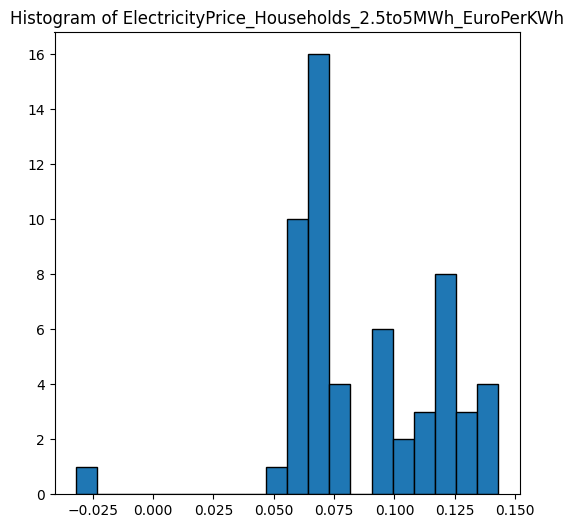

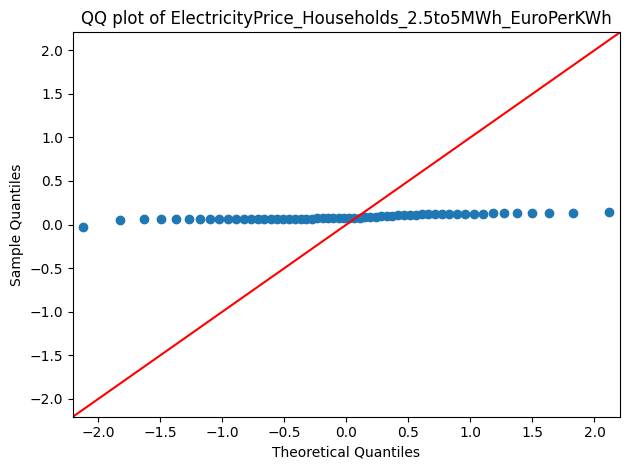

ShapiroResult(statistic=0.8810496926307678, pvalue=3.794524309341796e-05)


In [138]:
check_normality(df=energy_prices_processed, feature='ElectricityPrice_Households_2.5to5MWh_EuroPerKWh')

In [139]:
energy_prices_processed.isna().sum() / len(energy_prices_processed)

NaturalGasPrice_Households_LessThan_569m3_EuroPerM3      0.0
NaturalGasPrice_Households_569to5687m3_EuroPerM3         0.0
NaturalGasPrice_Households_MoreThan_5687m3_EuroPerM3     0.0
ElectricityPrice_Households_2.5to5MWh_EuroPerKWh         0.0
ElectricityPrice_Households_5to15MWh_EuroPerKWh          0.0
ElectricityPrice_Households_MoreThan_15MWh_EuroPerKWh    0.0
Year                                                     0.0
Month                                                    0.0
dtype: float64

## GDP

|Data     |Granularity |Year range|Source |
|---------|------------|----------|-------|
|GDP      |Yearly      |1995-2023 |CBS    |

In [217]:
yearly_GDP_path = 'processed_data/GDP.csv' 
yearly_GDP

,Periods,GDP_million_euros,GDP_growth_rate
0,1995,469502,NaN
1,1996,485928,3.498601
2,1997,506964,4.329036
3,1998,530609,4.664039
4,1999,557320,5.034027
5,2000,580703,4.195615
6,2001,594216,2.327007
7,2002,595507,0.217261
8,2003,596434,0.155666
9,2004,608273,1.984964


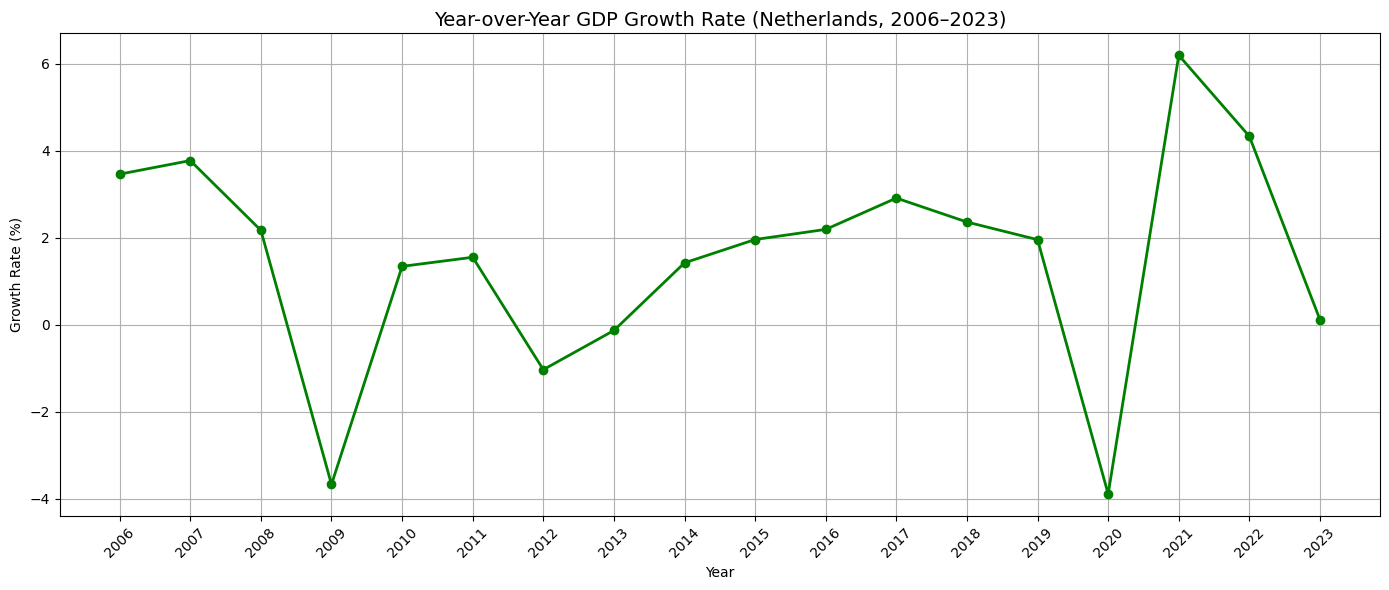

In [218]:
# Clean and prepare data
gdp_growth = yearly_GDP.dropna(subset=['GDP_growth_rate'])
gdp_growth = gdp_growth.drop_duplicates(subset='Periods')
gdp_growth = gdp_growth[gdp_growth['Periods'] >= 2006]
gdp_growth = gdp_growth.sort_values('Periods')
gdp_growth['Periods'] = gdp_growth['Periods'].astype(int)

# Plot with all years shown
plt.figure(figsize=(14, 6))
plt.plot(gdp_growth['Periods'], gdp_growth['GDP_growth_rate'], marker='o', color='green', linewidth=2)

# Set every year on x-axis
plt.xticks(gdp_growth['Periods'], rotation=45)

# Labels and title
plt.title('Year-over-Year GDP Growth Rate (Netherlands, 2006–2023)', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Growth Rate (%)')
plt.grid(True)
plt.tight_layout()

# Save and show
plt.savefig("plots/netherlands_gdp_growth_rate_per_year.png", dpi=300, bbox_inches='tight')
plt.show()


## Population

|Data       |Granularity |Year range|Source |
|-----------|------------|----------|-------|
|Population |Yearly      |1900-2023 |CBS    |

In [219]:
yearly_pop_path = 'processed_data/populationNL.csv' 
yearly_pop = pd.read_csv(yearly_pop_path)

yearly_pop.head()

,Year,Population
0,2006,16.33
1,2007,16.36
2,2008,16.41
3,2009,16.49
4,2010,16.57


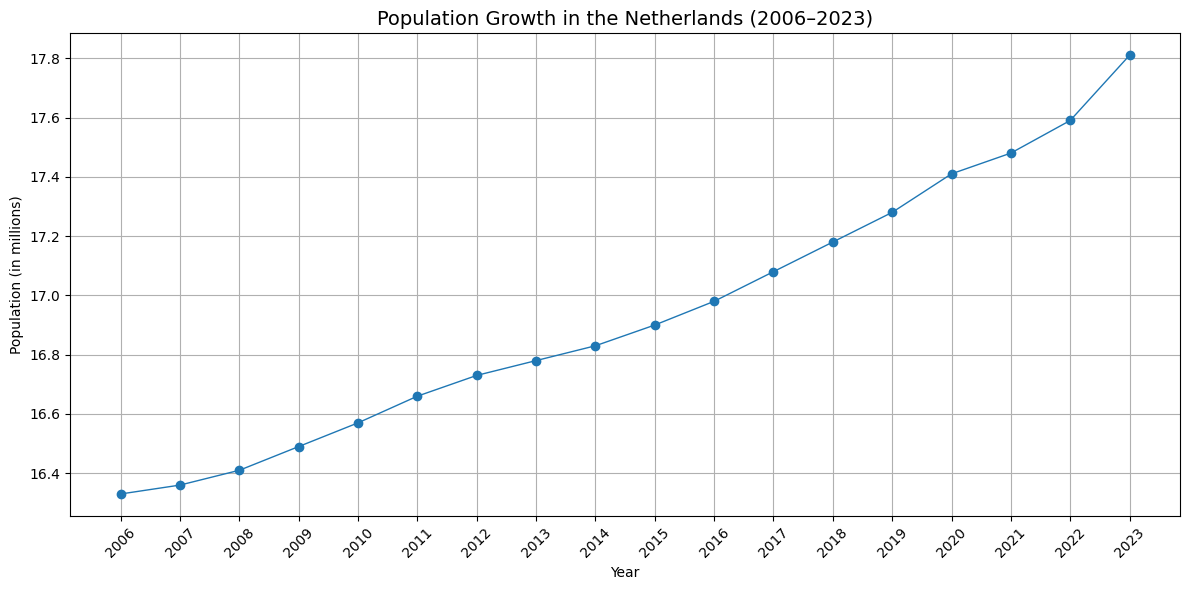

In [221]:
# Filter for years from 2006 onwards
pop_filtered = yearly_pop[yearly_pop['Year'] >= 2006]

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(pop_filtered['Year'], pop_filtered['Population'], marker='o', linewidth=1)

plt.title('Population Growth in the Netherlands (2006–2023)', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Population (in millions)')
plt.xticks(pop_filtered['Year'], rotation=45)  # Show all years from 2006
plt.grid(True)
plt.tight_layout()

plt.savefig("plots/population_growth_2006_2023.png", dpi=300, bbox_inches='tight')
plt.show()

In [222]:
# Calculate year-over-year percentage change
yearly_pop['GrowthRate'] = yearly_pop['Population'].pct_change() * 100 

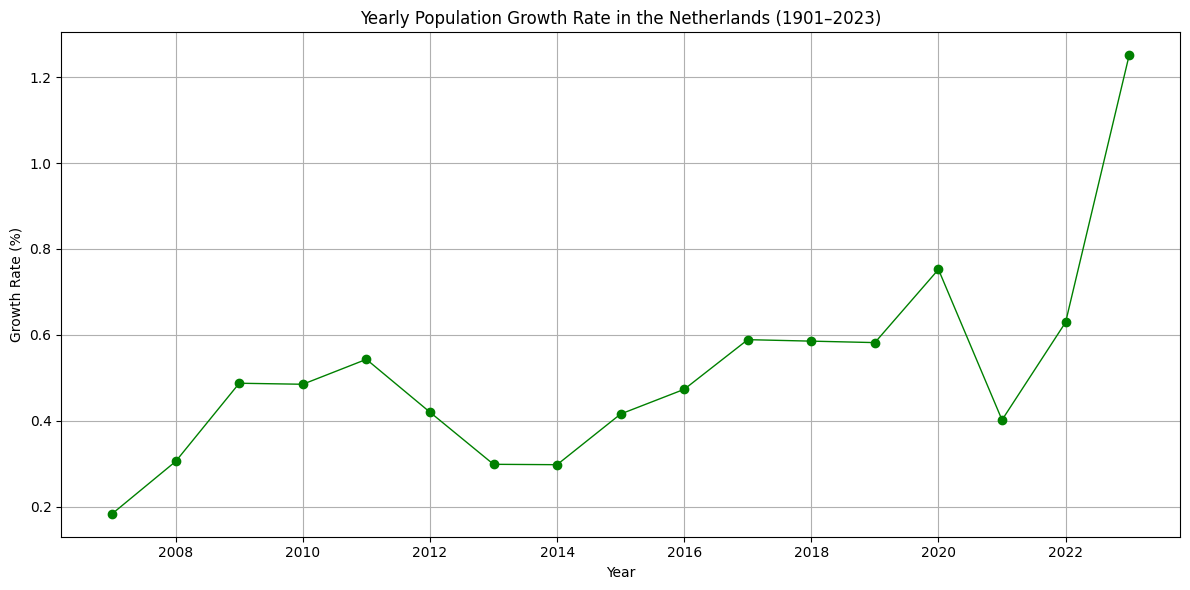

In [223]:
plt.figure(figsize=(12, 6))
plt.plot(yearly_pop['Year'], yearly_pop['GrowthRate'], color='green', marker='o', linewidth=1)

plt.title('Yearly Population Growth Rate in the Netherlands (1901–2023)')
plt.xlabel('Year')
plt.ylabel('Growth Rate (%)')
plt.grid(True)
plt.tight_layout()

plt.savefig("plots/population_growth_rate.png", dpi=300, bbox_inches='tight')
plt.show()

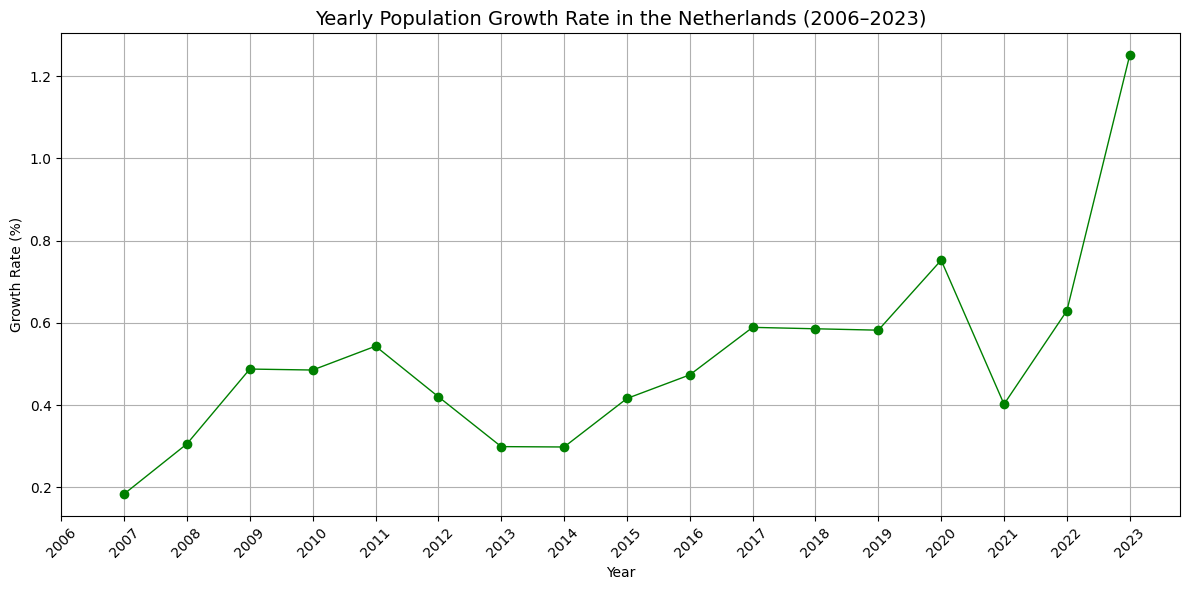

In [224]:
# Filter for years from 2006 onwards
pop_growth = yearly_pop[yearly_pop['Year'] >= 2006]

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(pop_growth['Year'], pop_growth['GrowthRate'], color='green', marker='o', linewidth=1)

plt.title('Yearly Population Growth Rate in the Netherlands (2006–2023)', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Growth Rate (%)')
plt.xticks(pop_growth['Year'], rotation=45)  # Show all years on x-axis
plt.grid(True)
plt.tight_layout()

plt.savefig("plots/population_growth_rate_2006_2023.png", dpi=300, bbox_inches='tight')
plt.show()

## Merge DataSets

In [191]:
# drop some weather and energy price columns for joining
weather_dropped = weather.drop(columns=['Year', 'WeekKey', 'day_of_week', 'Week'])
#energy_prices_processed.drop(columns=['MonthYear'], inplace=True)

# merge datasets
data.rename(columns={'date': 'Date'}, inplace=True)
df = data.merge(weather_dropped, how='left', on='Date')
df.rename(columns={'Month_x': 'Month'}, inplace=True)
df = df.merge(energy_prices_processed, on = ['Year', 'Month'], how = 'left')

df

,loadConsumption,Date,datetime,Hour,Year,Month,Season,DailyPrecipitation,MaxHourlyPrecipitation,HDMaxPrecipitation,...,HDMaxMeanWindspeed,MinHourlyMeanWindspeed,HDMinMeanWindspeed,Month_y,NaturalGasPrice_Households_LessThan_569m3_EuroPerM3,NaturalGasPrice_Households_569to5687m3_EuroPerM3,NaturalGasPrice_Households_MoreThan_5687m3_EuroPerM3,ElectricityPrice_Households_2.5to5MWh_EuroPerKWh,ElectricityPrice_Households_5to15MWh_EuroPerKWh,ElectricityPrice_Households_MoreThan_15MWh_EuroPerKWh
0,10215.0000,2006-01-01,2005-12-31 23:00:00,0,2006,12,Winter,0.0,0.0,1,...,1,1.0,15,1,NaN,NaN,NaN,NaN,NaN,NaN
1,9979.0000,2006-01-01,2006-01-01 00:00:00,1,2006,1,Winter,0.0,0.0,1,...,1,1.0,15,1,NaN,NaN,NaN,NaN,NaN,NaN
2,9460.0000,2006-01-01,2006-01-01 01:00:00,2,2006,1,Winter,0.0,0.0,1,...,1,1.0,15,1,NaN,NaN,NaN,NaN,NaN,NaN
3,8833.0000,2006-01-01,2006-01-01 02:00:00,3,2006,1,Winter,0.0,0.0,1,...,1,1.0,15,1,NaN,NaN,NaN,NaN,NaN,NaN
4,8525.0000,2006-01-01,2006-01-01 03:00:00,4,2006,1,Winter,0.0,0.0,1,...,1,1.0,15,1,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178599,12673.4650,2023-12-31,2023-12-31 19:00:00,20,2023,12,Winter,2.8,1.6,10,...,12,4.0,1,12,NaN,NaN,NaN,NaN,NaN,NaN
178600,12366.1950,2023-12-31,2023-12-31 20:00:00,21,2023,12,Winter,2.8,1.6,10,...,12,4.0,1,12,NaN,NaN,NaN,NaN,NaN,NaN
178601,12143.1775,2023-12-31,2023-12-31 21:00:00,22,2023,12,Winter,2.8,1.6,10,...,12,4.0,1,12,NaN,NaN,NaN,NaN,NaN,NaN
178602,11993.1200,2023-12-31,2023-12-31 22:00:00,23,2023,12,Winter,2.8,1.6,10,...,12,4.0,1,12,NaN,NaN,NaN,NaN,NaN,NaN


Flag hours on which precipitation/temperature/windspeed is at its min/max. Drop the corresponding hour columns

In [192]:
hour_cols = [
        'HDMaxPrecipitation',
        'HDMinTemperature',
        'HDMaxTemperature',
        'HDMaxMeanWindspeed',
        'HDMinMeanWindspeed'
    ]

    
for i in hour_cols:
    flag_col_name = i[2:] + 'HourFlag'
    df[flag_col_name] = (df[i] == df['Hour']).astype(int)

df.drop(columns=hour_cols, inplace=True)

In [193]:
df.isna().sum() / len(df) * 100

loadConsumption                                           0.000000
Date                                                      0.000000
datetime                                                  0.000000
Hour                                                      0.000000
Year                                                      0.000000
Month                                                     0.000000
Season                                                    0.000000
DailyPrecipitation                                        0.000000
MaxHourlyPrecipitation                                    0.000000
DailyMeanTemperature                                      0.000000
HourlyMinTemperature                                      0.000000
HourlyMaxTemperature                                      0.000000
DailyMeanWindspeed                                        0.000000
MaxHourlyMeanWindspeed                                    0.000000
MinHourlyMeanWindspeed                                    0.00

In [194]:
print('prices', energy_prices_processed['Year'].min(), energy_prices_processed['Year'].max())

prices 2009 2024


In [195]:
df = df[df['Year'] >= 2009]

In [196]:
df.isna().sum() / len(df) * 100

loadConsumption                                           0.000000
Date                                                      0.000000
datetime                                                  0.000000
Hour                                                      0.000000
Year                                                      0.000000
Month                                                     0.000000
Season                                                    0.000000
DailyPrecipitation                                        0.000000
MaxHourlyPrecipitation                                    0.000000
DailyMeanTemperature                                      0.000000
HourlyMinTemperature                                      0.000000
HourlyMaxTemperature                                      0.000000
DailyMeanWindspeed                                        0.000000
MaxHourlyMeanWindspeed                                    0.000000
MinHourlyMeanWindspeed                                    0.00

In [197]:
len(weather[weather['HDMaxPrecipitation'] == 1]) / len(weather) * 100

45.50259728424314

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


HDMinTemperature
1     1242
2      654
3      783
4     1346
5     1191
6      742
7      509
8      302
9       87
10      32
11      17
12      17
13      16
14      12
15      12
16      11
17      40
18      63
19      98
20     129
21     211
22     331
23     556
24    2572
Name: Date, dtype: int64


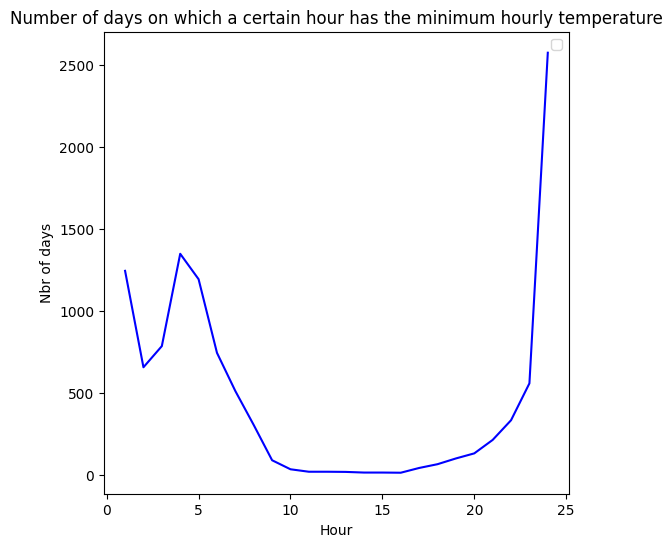

In [198]:
# group weather df by hourly min temperature
grouped_hourly_min_temperature = weather.groupby('HDMinTemperature')['Date'].count()
print(grouped_hourly_min_temperature)

# plot
plt.figure(figsize=(6, 6))

plt.plot(
    grouped_hourly_min_temperature.index, 
    grouped_hourly_min_temperature.values, 
    color='blue'
)
plt.title('Number of days on which a certain hour has the minimum hourly temperature')
plt.xlabel('Hour')
plt.ylabel('Nbr of days')
plt.legend()

In [199]:
len(weather[weather['HDMinTemperature'] == 24]) / len(weather) * 100

23.43935113460312

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


HDMaxTemperature
1      363
2       67
3       46
4       31
5       32
6       21
7        9
8       18
9       70
10     189
11     455
12    1013
13    1860
14    2577
15    2064
16    1082
17     375
18     107
19      72
20      63
21      55
22      78
23      97
24     229
Name: Date, dtype: int64


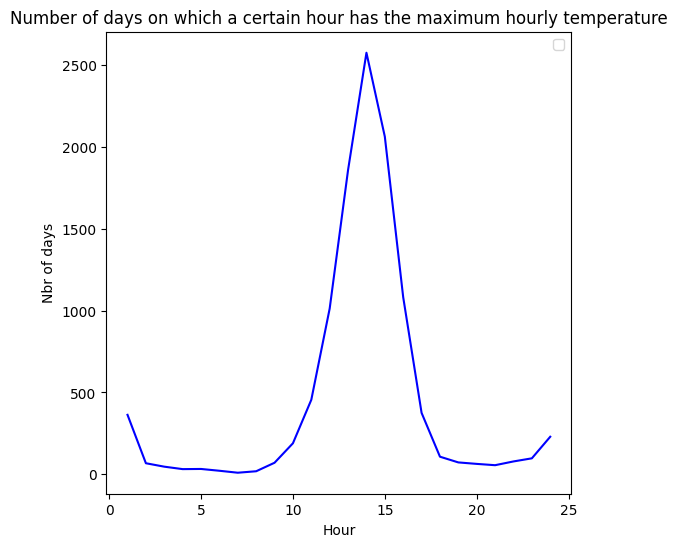

In [200]:
# group weather df by hourly max temperature
grouped_hourly_max_temperature = weather.groupby('HDMaxTemperature')['Date'].count()
print(grouped_hourly_max_temperature)

# plot
plt.figure(figsize=(6, 6))

plt.plot(
    grouped_hourly_max_temperature.index, 
    grouped_hourly_max_temperature.values, 
    color='blue'
)
plt.title('Number of days on which a certain hour has the maximum hourly temperature')
plt.xlabel('Hour')
plt.ylabel('Nbr of days')
plt.legend()

In [201]:
len(weather[weather['HDMaxTemperature'] == 14]) / len(weather) * 100

23.484917524833683

In [202]:
# group by week key to get max temperature of the week
max_temp_by_week = weather.groupby('WeekKey')['DailyMeanTemperature'].max()

# join this back to the weather df and rename columns
weather_joined = weather.merge(max_temp_by_week, left_on='WeekKey', right_index=True)
weather_joined.rename(
    columns=
    {
        'DailyMeanTemperature_x':'DailyMeanTemperature',
        'DailyMeanTemperature_y':'MaxTemperatureOfWeek'
    }, 
    inplace=True
)

# check which day had the max temperature
weather_joined['DayWithMaxTemp'] = weather_joined['DailyMeanTemperature'] == weather_joined['MaxTemperatureOfWeek']

# check how often a certain day has the max temperature
weather_joined[weather_joined['DayWithMaxTemp'] == True]['day_of_week'].value_counts()

day_of_week
Monday       332
Sunday       310
Tuesday      211
Friday       199
Wednesday    199
Saturday     194
Thursday     185
Name: count, dtype: int64

In [203]:
# group by week key to get max temperature of the week
weather_in_winter = weather[weather['Date'].dt.month.isin([12, 1, 2])]

max_temp_by_week = weather_in_winter.groupby('WeekKey')['DailyMeanTemperature'].max()

# join this back to the weather df and rename columns
winter_joined = weather_in_winter.merge(max_temp_by_week, left_on='WeekKey', right_index=True)
winter_joined.rename(
    columns=
    {
        'DailyMeanTemperature_x':'DailyMeanTemperature',
        'DailyMeanTemperature_y':'MaxTemperatureOfWeek'
    }, 
    inplace=True
)

# check which day had the max temperature
winter_joined['DayWithMaxTemp'] = winter_joined['DailyMeanTemperature'] == winter_joined['MaxTemperatureOfWeek']

# check how often a certain day has the max temperature
winter_joined[winter_joined['DayWithMaxTemp'] == True]['day_of_week'].value_counts()

day_of_week
Sunday       86
Monday       86
Friday       57
Wednesday    55
Saturday     54
Tuesday      51
Thursday     44
Name: count, dtype: int64

## Renewable Energy

In [204]:
renewable_erngy_path = 'processed_data/renwableEnergy.csv'
renewaleEnergy = pd.read_csv(renewable_erngy_path)
renewaleEnergy.head()

,Year,GeothermalHeat,AmbientAirHeat,TotalGeothermal&GroundEnergy,TotalBiomass,TotalRes(excl.Stat.Transfer),TotalRes(incl.Stat.Transfer),Totaal windenergie,TotalSolarEnergy,Total Including Non-Renewable,Hydropower,OnshoreWindEnergy,OffshoreWindEnergy,SolarPower,SolarThermalEnergy
0,2006,840.0,90.0,840.0,52156.0,63478.0,63478.0,9145.0,886.0,2284781.0,361.0,8917.0,228.0,132.0,755.0
1,2007,1141.0,106.0,1141.0,60188.0,74123.0,74123.0,11396.0,934.0,2247857.0,358.0,10304.0,1092.0,135.0,798.0
2,2008,1488.0,195.0,1584.0,64823.0,82081.0,82081.0,14131.0,988.0,2282493.0,360.0,12154.0,1977.0,143.0,846.0
3,2009,1841.0,351.0,1983.0,73747.0,93660.0,93660.0,16131.0,1088.0,2195534.0,360.0,13543.0,2588.0,162.0,926.0
4,2010,2183.0,536.0,2501.0,71605.0,92411.0,92411.0,16210.0,1196.0,2359420.0,364.0,13455.0,2755.0,201.0,994.0


In [205]:
renewaleEnergy.isna().sum() / len(renewaleEnergy)

Year                             0.0
GeothermalHeat                   0.0
AmbientAirHeat                   0.0
TotalGeothermal&GroundEnergy     0.0
TotalBiomass                     0.0
TotalRes(excl.Stat.Transfer)     0.0
TotalRes(incl.Stat.Transfer)     0.0
Totaal windenergie               0.0
TotalSolarEnergy                 0.0
Total Including Non-Renewable    0.0
Hydropower                       0.0
OnshoreWindEnergy                0.0
OffshoreWindEnergy               0.0
SolarPower                       0.0
SolarThermalEnergy               0.0
dtype: float64

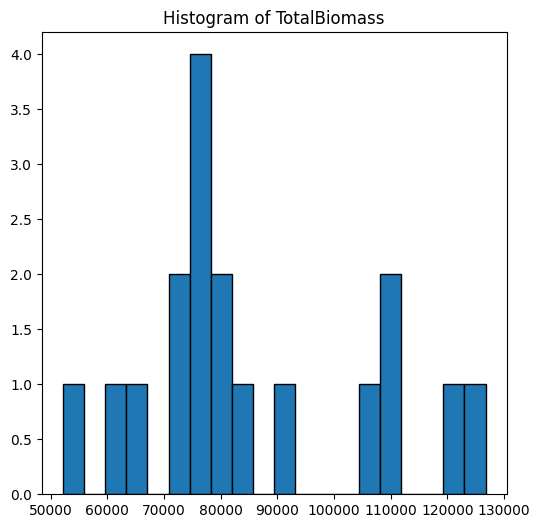

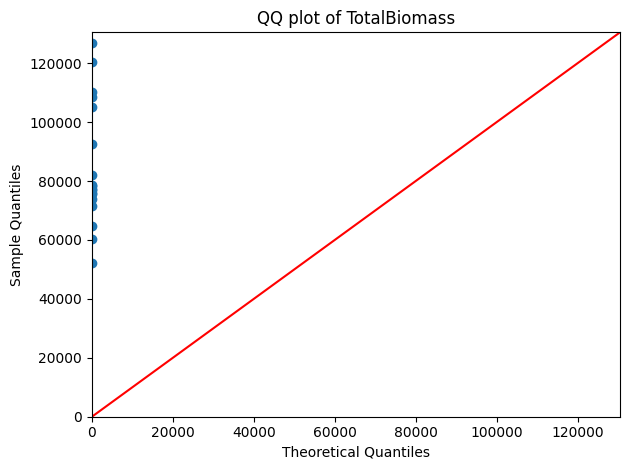

ShapiroResult(statistic=0.9196193814277649, pvalue=0.12728099524974823)


In [206]:
check_normality(df=renewaleEnergy, feature='TotalBiomass')

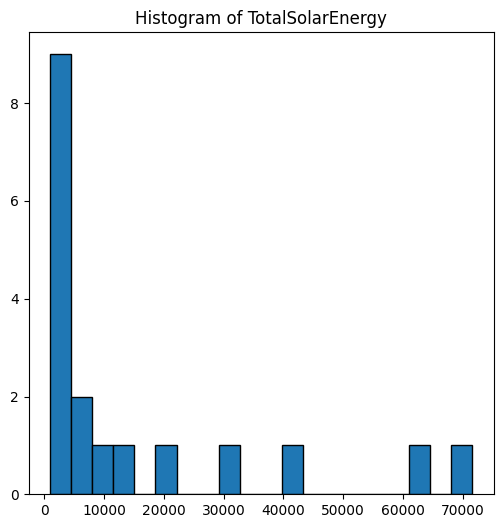

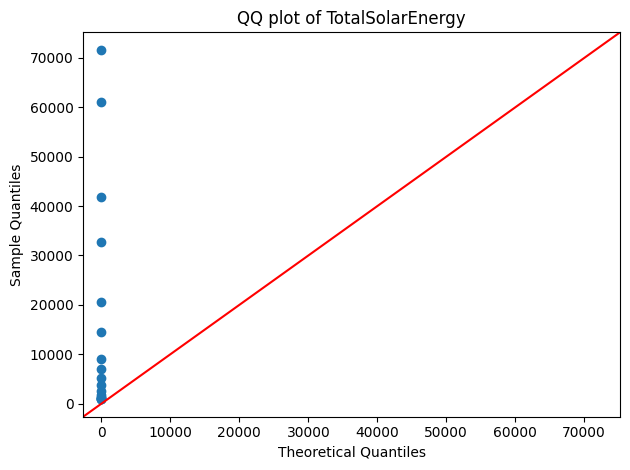

ShapiroResult(statistic=0.7122098207473755, pvalue=0.00011111657659057528)


In [207]:
check_normality(df=renewaleEnergy, feature='TotalSolarEnergy')

In [208]:
renewaleEnergy

,Year,GeothermalHeat,AmbientAirHeat,TotalGeothermal&GroundEnergy,TotalBiomass,TotalRes(excl.Stat.Transfer),TotalRes(incl.Stat.Transfer),Totaal windenergie,TotalSolarEnergy,Total Including Non-Renewable,Hydropower,OnshoreWindEnergy,OffshoreWindEnergy,SolarPower,SolarThermalEnergy
0,2006,840.0,90.0,840.0,52156.0,63478.0,63478.0,9145.0,886.0,2284781.0,361.0,8917.0,228.0,132.0,755.0
1,2007,1141.0,106.0,1141.0,60188.0,74123.0,74123.0,11396.0,934.0,2247857.0,358.0,10304.0,1092.0,135.0,798.0
2,2008,1488.0,195.0,1584.0,64823.0,82081.0,82081.0,14131.0,988.0,2282493.0,360.0,12154.0,1977.0,143.0,846.0
3,2009,1841.0,351.0,1983.0,73747.0,93660.0,93660.0,16131.0,1088.0,2195534.0,360.0,13543.0,2588.0,162.0,926.0
4,2010,2183.0,536.0,2501.0,71605.0,92411.0,92411.0,16210.0,1196.0,2359420.0,364.0,13455.0,2755.0,201.0,994.0
5,2011,2538.0,737.0,2854.0,76881.0,99256.0,99256.0,17010.0,1416.0,2192915.0,358.0,14336.0,2674.0,376.0,1040.0
6,2012,2852.0,961.0,3347.0,78470.0,102676.0,102676.0,17780.0,1757.0,2203277.0,361.0,14963.0,2817.0,686.0,1070.0
7,2013,3147.0,1230.0,4140.0,75825.0,103463.0,103463.0,19324.0,2582.0,2205198.0,362.0,16676.0,2648.0,1476.0,1106.0
8,2014,3404.0,1592.0,4906.0,77317.0,108835.0,108835.0,20914.0,3739.0,2009118.0,367.0,18215.0,2700.0,2611.0,1128.0
9,2015,3634.0,2019.0,6082.0,78707.0,117192.0,117192.0,24900.0,5127.0,2046519.0,355.0,21174.0,3727.0,3991.0,1137.0


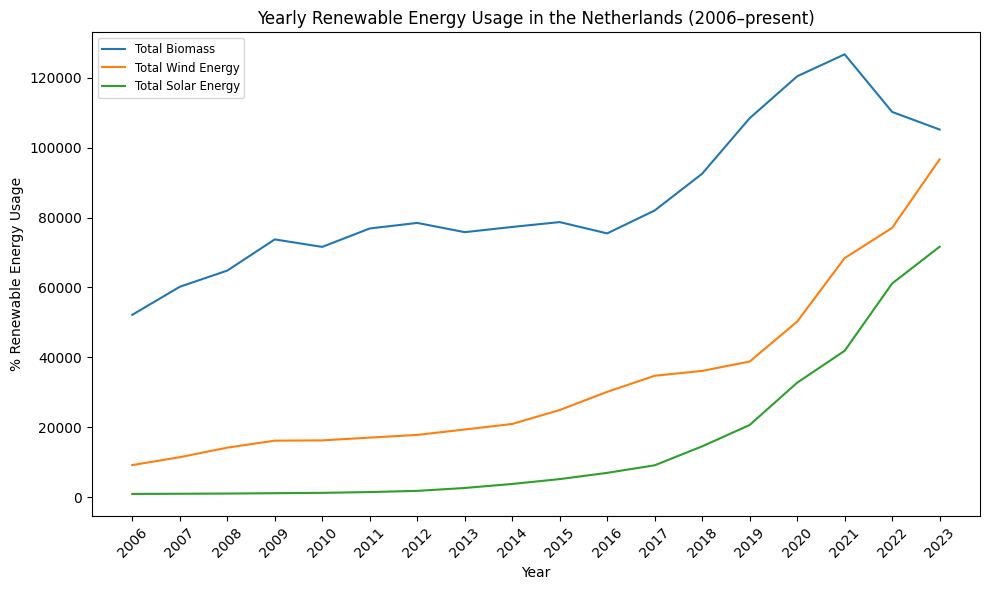

In [209]:
import matplotlib.pyplot as plt

# Ensure 'Year' is a column and set it as index if needed

#renewaleEnergy.set_index('Year', inplace=True)  

# Filter for data from 2015 onwards
#filtered_data = renewaleEnergy[renewaleEnergy.index >= 2015]

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(renewaleEnergy['Year'], renewaleEnergy['TotalBiomass'], label='Total Biomass')
ax.plot(renewaleEnergy['Year'], renewaleEnergy['Totaal windenergie'], label='Total Wind Energy')
ax.plot(renewaleEnergy['Year'], renewaleEnergy['TotalSolarEnergy'], label='Total Solar Energy')

ax.set_xticks(renewaleEnergy['Year'])
ax.set_xticklabels(renewaleEnergy['Year'].astype(int), rotation=45)

ax.set_xlabel('Year')
ax.set_ylabel('% Renewable Energy Usage')
ax.set_title('Yearly Renewable Energy Usage in the Netherlands (2006–present)')
ax.legend(fontsize='small')

plt.tight_layout()
plt.savefig("plots/yearlyrenewablenergyUsage.png", dpi=300, bbox_inches='tight')
plt.show()

### Analysis 1: Per day we can see on which hour the minimum/maximum precipitation, windspeed and temperature occurred. We want to know how often a certain hour has this min/max. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


HDMaxPrecipitation
1     4993
2      320
3      267
4      267
5      256
6      248
7      265
8      228
9      234
10     261
11     247
12     222
13     266
14     264
15     248
16     284
17     254
18     273
19     269
20     222
21     232
22     244
23     264
24     345
Name: Date, dtype: int64


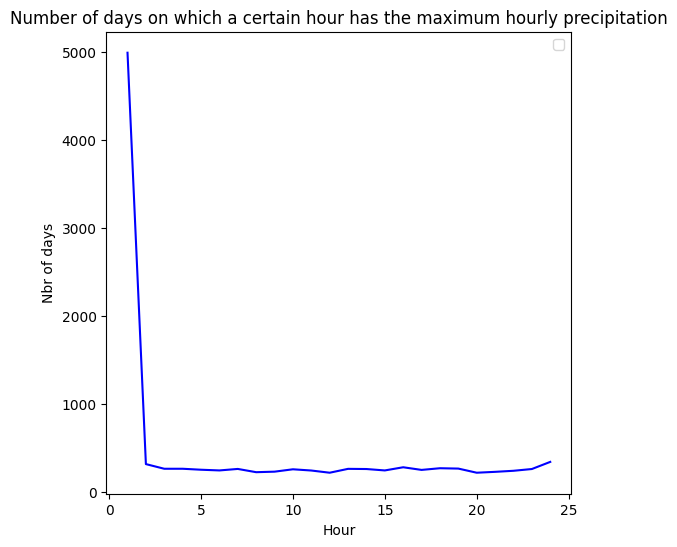

In [210]:
# group weather df by hourly preciptitation
grouped_hourly_preciptitation = weather.groupby('HDMaxPrecipitation')['Date'].count()
print(grouped_hourly_preciptitation)

# plot
plt.figure(figsize=(6, 6))

plt.plot(
    grouped_hourly_preciptitation.index, 
    grouped_hourly_preciptitation.values, 
    color='blue'
)
plt.title('Number of days on which a certain hour has the maximum hourly precipitation')
plt.xlabel('Hour')
plt.ylabel('Nbr of days')
plt.legend()

In [211]:
len(weather[weather['HDMaxPrecipitation'] == 1]) / len(weather) * 100

45.50259728424314

First hour of the day( hour= 1) has MaxPrecipitation, and that is in about 46% of the days

Let's check what hour has the maximum temp.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


HDMaxTemperature
1      363
2       67
3       46
4       31
5       32
6       21
7        9
8       18
9       70
10     189
11     455
12    1013
13    1860
14    2577
15    2064
16    1082
17     375
18     107
19      72
20      63
21      55
22      78
23      97
24     229
Name: Date, dtype: int64


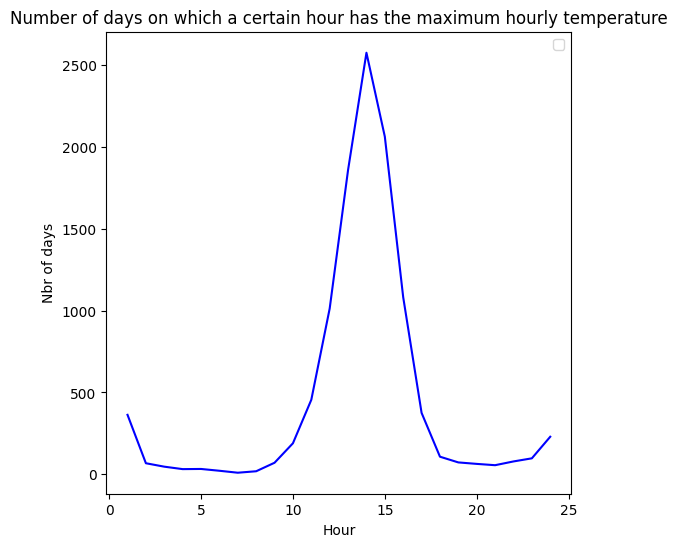

In [212]:
# group weather df by hourly max temperature
grouped_hourly_max_temperature = weather.groupby('HDMaxTemperature')['Date'].count()
print(grouped_hourly_max_temperature)

# plot
plt.figure(figsize=(6, 6))

plt.plot(
    grouped_hourly_max_temperature.index, 
    grouped_hourly_max_temperature.values, 
    color='blue'
)
plt.title('Number of days on which a certain hour has the maximum hourly temperature')
plt.xlabel('Hour')
plt.ylabel('Nbr of days')
plt.legend()

In [213]:
len(weather[weather['HDMaxTemperature'] == 14]) / len(weather) * 100

23.484917524833683

In [214]:
len(weather[weather['HDMaxTemperature'] == 15]) / len(weather) * 100

18.809805887177617

The maximum temprature is around 14.00, in 23% of  the days, and around 15.00 in 19% of the days

###  Decomposition of load consumption data

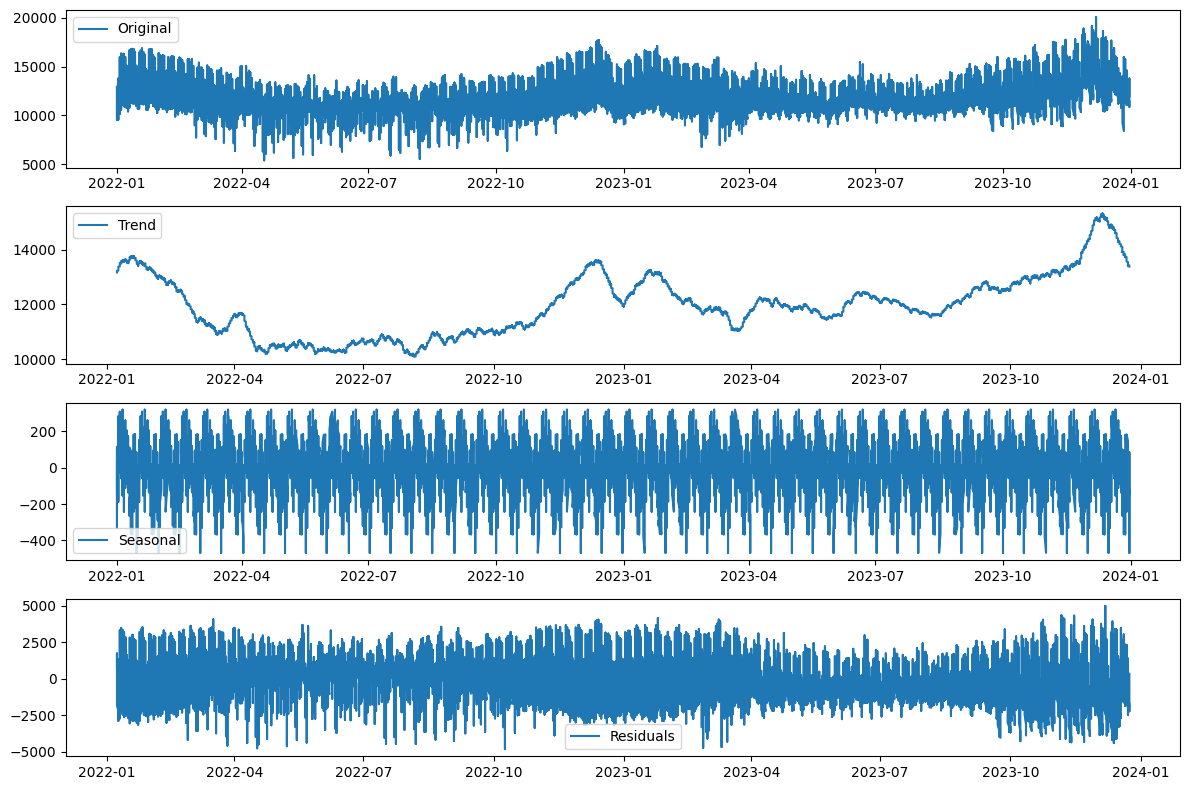

In [215]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Set 'Date' as index and ensure it's datetime
df_decomp = df_decomp[df_decomp.index.year >= 2022]
#df_decomp['Date'] = pd.to_datetime(df_decomp['Date'])
#df_decomp.set_index('Date', inplace=True)


# Perform additive decomposition
result = seasonal_decompose(df_decomp['loadConsumption'], model='additive', period=365)

# Plot the decomposition
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(df_decomp.index, df_decomp['loadConsumption'], label='Original')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Trend')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Seasonal')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residuals')
plt.legend()

plt.tight_layout()
plt.savefig("plots/seasonal_decomposition.png", dpi=300, bbox_inches='tight')
plt.show()

- Original Series
1. The top panel clearly reveals the seasonal fluctuations on top of a moderately increasing trend.
2. Sharp dips and peaks still appear, possibly reflecting weather effects, holidays, or measurement anomalies.
- Trend Component
1. The trend line now reflects  fine-grained long-term movements.
2. The overall pattern seems cyclical, with a downward drift until mid-2022 followed by a noticeable rise in late 2023.
3. This rise may correlate with post-pandemic economic recovery or increased energy demand during colder months.
- Seasonal Component
1. There is a clear seasonal patter
2. The repeating weekly cycles are now evident, consistent with regular industrial and residential energy usage patterns.
3. Amplitude appears relatively stable, indicating that seasonal variation is not strongly dependent on the overall level, justifying your choice of the additive model.
- Residuals
1. Residuals  appear mostly centered around zero, with no obvious drift or heteroscedasticity.
2. The presence of spikes suggests specific days with unexpected deviations, which could be further explored through anomaly detection methods or external events.